# Machine Translation with Transformer 

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

![](assets/transformer1.png)

## Introduction

Similar to the Convolutional Sequence-to-Sequence model, the Transformer does not use any recurrence. It also does not use any convolutional layers. Instead the model is entirely made up of linear layers, attention mechanisms and normalization. 

As of January 2020, Transformers are the dominant architecture in NLP and are used to achieve state-of-the-art results for many tasks and it appears as if they will be for the near future. 

The most popular Transformer variant is [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) and pre-trained versions of BERT are commonly used to replace the embedding layers - if not more - in NLP models. 

A common library used when dealing with pre-trained transformers is the [Transformers](https://huggingface.co/transformers/) library, see [here](https://huggingface.co/transformers/pretrained_models.html) for a list of all pre-trained models available.

The differences between the implementation in this notebook and the paper are:
- we use a learned positional encoding instead of a static one
- we use the standard Adam optimizer with a static learning rate instead of one with warm-up and cool-down steps
- we do not use label smoothing

We make all of these changes as they closely follow BERT's set-up and the majority of Transformer variants use a similar set-up.

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We'll then create our tokenizers as before.

In [3]:
spacy_ln = spacy.load('en')
spacy_en = spacy.load('en')

In [4]:
def tokenize_ln(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return text.split() # [tok.text for tok in spacy_ln.tokenizer(text)] #text.split()

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return text.split() #[tok.text for tok in spacy_en.tokenizer(text)] #text.split()

In [5]:
tokenize_ln('Hello I am Salomon')

['Hello', 'I', 'am', 'Salomon']

Our fields are the same as the previous notebook. The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 

In [6]:
SRC = Field(tokenize = tokenize_ln, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

We then load the Multi30k dataset and build the vocabulary.

In [7]:
from torchtext import data, datasets

# train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
#                                                     fields = (SRC, TRG))

MAX_LEN = 90


# load our dataset
train_data, valid_data = datasets.TranslationDataset.splits(train="train", validation="valid", test=None,
    path = "./data", exts = ('.en', '.ln'), fields=(SRC, TRG),
    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
    len(vars(x)['trg']) <= MAX_LEN
)

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Finally, we define the device and the data iterator.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
BATCH_SIZE = 32

train_iterator, valid_iterator = BucketIterator.splits(
    (train_data, valid_data), 
     batch_size = BATCH_SIZE,
     device = device)

# train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
#     (train_data, valid_data, test_data), 
#      batch_size = BATCH_SIZE,
#      device = device)

In [11]:
next(iter(train_iterator)).src

tensor([[    2,   246,   119,  ...,     1,     1,     1],
        [    2,   310,     6,  ...,     1,     1,     1],
        [    2,     6, 10835,  ...,     1,     1,     1],
        ...,
        [    2,   548,    38,  ...,     1,     1,     1],
        [    2,    19,   652,  ...,     1,     1,     1],
        [    2,   152,     5,  ...,     1,     1,     1]], device='cuda:0')

## Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

### Encoder

Similar to the ConvSeq2Seq model, the Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

![](assets/transformer-encoder.png)

First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<sos>` (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, `hid_dim`. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which is then output and can be used by the decoder.

The source mask, `src_mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information.

In [12]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained. We first pass the source sentence and its mask into the *multi-head attention layer*, then perform dropout on it, apply a residual connection and pass it through a [Layer Normalization](https://arxiv.org/abs/1607.06450) layer. We then pass it through a *position-wise feedforward* layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers. 

The mutli head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it *self attention*.

[This](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) article goes into more detail about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](assets/transformer-attention.png)

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

The other main block inside the encoder layer is the *position-wise feedforward layer* This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

Why is this used? Unfortunately, it is never explained in the paper.

BERT uses the [GELU](https://arxiv.org/abs/1606.08415) activation function, which can be used by simply switching `torch.relu` for `F.gelu`. Why did they use GELU? Again, it is never explained.

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

![](assets/transformer-decoder.png)

The decoder is similar to encoder, however it now has two multi-head attention layers. A *masked multi-head attention layer* over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

The decoder uses positional embeddings and combines - via an elementwise sum - them with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long. This can be increased if desired.

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, `enc_src`, and the source and target masks. Note that the number of layers in the encoder does not have to be equal to the number of layers in the decoder, even though they are both denoted by $N$.

The decoder representation after the $N^{th}$ layer is then passed through a linear layer, `fc_out`. In PyTorch, the softmax operation is contained within our loss function, so we do not explicitly need to use a softmax layer here.

As well as using the source mask, as we did in the encoder to prevent our model attending to `<pad>` tokens, we also use a target mask. This will be explained further in the `Seq2Seq` model which encapsulates both the encoder and decoder, but the gist of it is that it performs a similar operation as the decoder padding in the convolutional sequence-to-sequence model. As we are processing all of the target tokens at once in parallel we need a method of stopping the decoder from "cheating" by simply "looking" at what the next token in the target sequence is and outputting it. 

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [15]:
class Decoder(nn.Module):
    
    """
    Decoder Transformer class
    """
    
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`. 

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This `self_attention` layer uses the target sequence mask, `trg_mask`, in order to prevent the decoder from "cheating" by paying attention to tokens that are "ahead" of the one it is currently processing as it processes all tokens in the target sentence in parallel.

The second is how we actually feed the encoded source sentence, `enc_src`, into our decoder. In this multi-head attention layer the queries are the decoder representations and the keys and values are the decoder representations. Here, the source mask, `src_mask` is used to prevent the multi-head attention layer from attending to `<pad>` tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers. 

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

In [16]:
class DecoderLayer(nn.Module):
    
    """
    Decoder Layer Transformer class
    """
    
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [18]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [19]:
print(f"Source vocab: {INPUT_DIM}")
print(f"Target vocab: {OUTPUT_DIM}")

Source vocab: 41240
Target vocab: 41768


Then, use them to define our whole sequence-to-sequence encapsulating model.

In [20]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 35,989,288 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [22]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [23]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [24]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [26]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
#         if output.shape[0] != trg.shape[0] or output.shape[1]!=6256:
#             ipdb.set_trace()
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [29]:
# !export CUDA_LAUNCH_BLOCKING=1
import ipdb

In [ ]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss        
        print('Saving Model ...')
        torch.save(model.state_dict(), 'model/Model_MT_'+str(best_valid_loss)[:4]+'.pt')
        print('*****************************************************')
        print(f'best loss: [epoch: {epoch}], [valid loss {best_valid_loss}]')
        print('*****************************************************')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Saving Model ...
*****************************************************
best loss: [epoch: 0], [valid loss 1.4111332705792259]
*****************************************************
Epoch: 01 | Time: 19m 28s
	Train Loss: 3.026 | Train PPL:  20.618
	 Val. Loss: 1.411 |  Val. PPL:   4.101
Saving Model ...
*****************************************************
best loss: [epoch: 1], [valid loss 1.1523114689132747]
*****************************************************
Epoch: 02 | Time: 19m 18s
	Train Loss: 2.163 | Train PPL:   8.696
	 Val. Loss: 1.152 |  Val. PPL:   3.166
Saving Model ...
*****************************************************
best loss: [epoch: 2], [valid loss 1.0556168593028012]
*****************************************************
Epoch: 03 | Time: 19m 12s
	Train Loss: 1.938 | Train PPL:   6.947
	 Val. Loss: 1.056 |  Val. PPL:   2.874
Saving Model ...


We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [31]:
model.load_state_dict(torch.load('model/Model_MT.pt'))

valid_loss = evaluate(model, valid_iterator, criterion)

print(f'| Valid Loss: {valid_loss:.3f} | Test PPL: {math.exp(valid_loss):7.3f} |')

| Valid Loss: 0.672 | Test PPL:   1.958 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [32]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [33]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [91]:
Sentence = "I am from ghana"
src = tokenize_ln(Sentence)

print(f'src = {src}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['I', 'am', 'from', 'ghana']
predicted trg = ['nazali', 'moto', 'ya', 'ghana', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

In [89]:
# display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [37]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['jehovah', 'is', 'the', 'name', 'of', 'god', 'as', 'revealed', 'in', 'the', 'bible', '.']
trg = ['yehova', 'ezali', 'nkombo', 'ya', 'nzambe', 'na', 'biblia', '.']


The model translates it by switching *is running* to just *running*, but it is an acceptable swap.

In [38]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['yehova', 'ezali', 'nkombo', 'ya', 'nzambe', 'oyo', 'biblia', 'elobeli', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

/home/aims/anaconda3/envs/s2s/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aims/anaconda3/envs/s2s/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


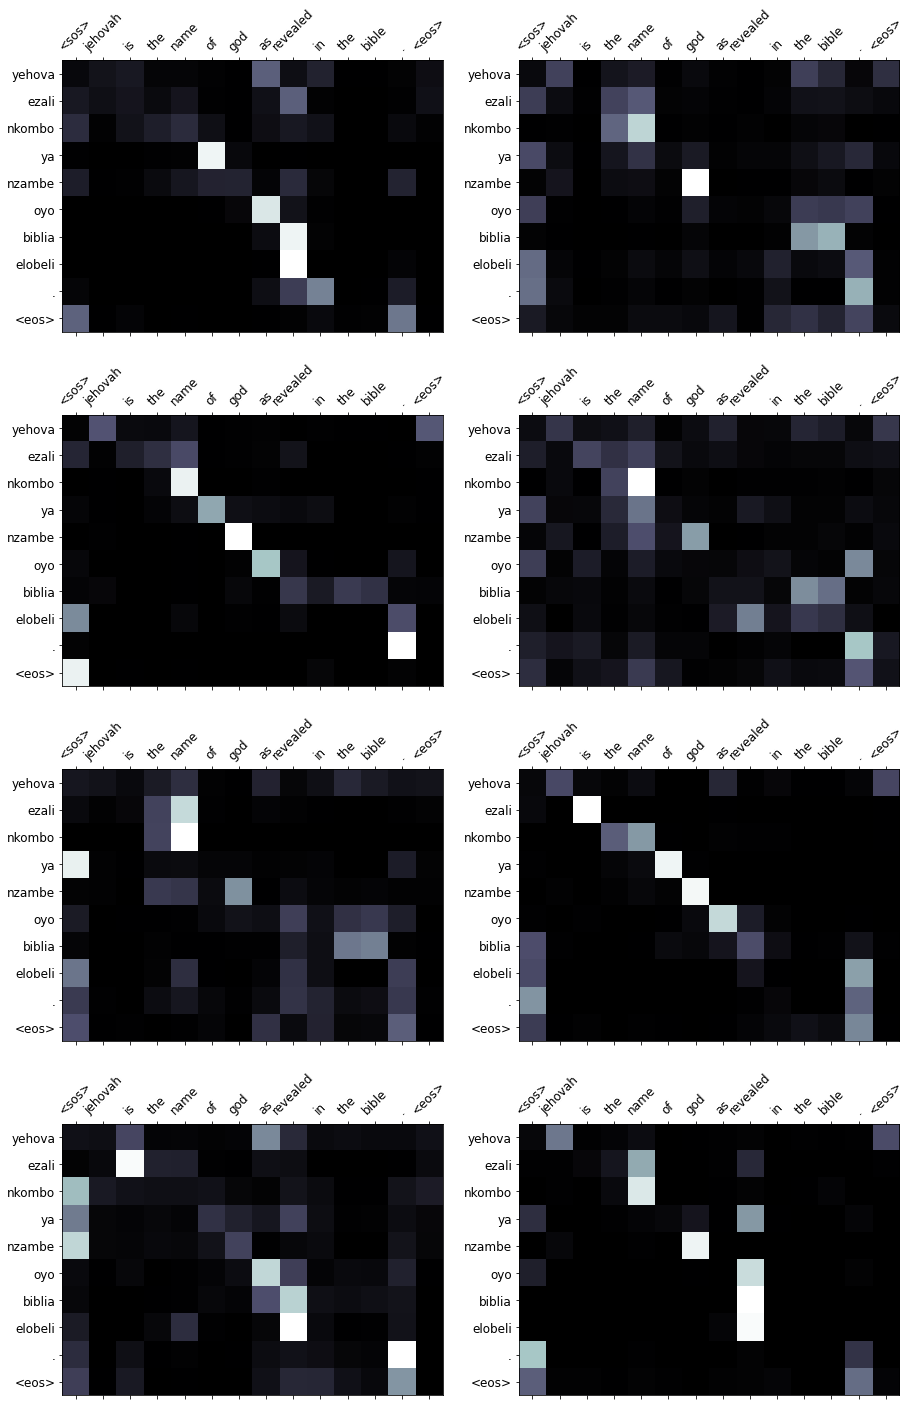

In [39]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [40]:
# example_idx = 10

# src = vars(test_data.examples[example_idx])['src']
# trg = vars(test_data.examples[example_idx])['trg']

# print(f'src = {src}')
# print(f'trg = {trg}')

A decent translation with *young* being omitted.

In [41]:
# translation, attention = translate_sentence(src, SRC, TRG, model, device)

# print(f'predicted trg = {translation}')

In [42]:
# display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [43]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 35.08, which beats the 33.3 of the convolutional sequence-to-sequence model and 28.2 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [44]:
bleu_score = calculate_bleu(valid_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 54.74


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP. 

# Automatic Speech Recognition with Transformer 

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper.

![](assets/ST.png)

In [1]:
from __future__ import print_function

import json
import time
import math
import numpy as np

import sys
import ipdb
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import logging
from tqdm import tqdm

import os
import subprocess
import torchaudio
from tempfile import NamedTemporaryFile

import librosa

import scipy.signal

import random
from collections import Counter

from torch.distributed import get_rank
from torch.distributed import get_world_size
from torch.utils.data import Dataset, DataLoader

from torch.utils.data.sampler import Sampler

from scipy import spatial
import unicodedata
import string
import re
# from stanfordcorenlp import StanfordCoreNLP


import fnmatch
import io
import IPython

# UTILS

## Audio

In [2]:
def load_audio(path):
    sound, _ = torchaudio.load(path, normalization=True)
    sound = sound.numpy().T
    
#     print(len(sound.shape))
    
    if len(sound.shape) > 1:
        if sound.shape[1] == 1:
            sound = sound.squeeze()
        else:
            sound = sound.mean(axis=1)  # multiple channels, average
    return sound


def get_audio_length(path):
    output = subprocess.check_output(
        ['soxi -D \"%s\"' % path.strip()], shell=True)
    return float(output)

def audio_with_sox(path, sample_rate, start_time, end_time):
    """
    crop and resample the recording with sox and loads it.
    """
    with NamedTemporaryFile(suffix=".wav") as tar_file:
        tar_filename = tar_file.name
        sox_params = "sox \"{}\" -r {} -c 1 -b 16 -e si {} trim {} ={} >/dev/null 2>&1".format(
            path, sample_rate,
            tar_filename, start_time,
            end_time)
        
        os.system(sox_params)
        y = load_audio(tar_filename)
        return y

def augment_audio_with_sox(path, sample_rate, tempo, gain):
    """
    Changes tempo and gain of the recording with sox and loads it.
    """
    with NamedTemporaryFile(suffix=".wav") as augmented_file:
        augmented_filename = augmented_file.name
        sox_augment_params = ["tempo", "{:.3f}".format(
            tempo), "gain", "{:.3f}".format(gain)]
        sox_params = "sox \"{}\" -r {} -c 1 -b 16 -e si {} {} >/dev/null 2>&1".format(
            path, sample_rate, augmented_filename, " ".join(sox_augment_params))
        os.system(sox_params)
        y = load_audio(augmented_filename)
        return y


def load_randomly_augmented_audio(path, sample_rate=16000, tempo_range=(0.85, 1.15), 
                                  gain_range=(-6, 8)):
    """
    Picks tempo and gain uniformly, applies it to the utterance by using sox utility.
    Returns the augmented utterance.
    """
    low_tempo, high_tempo = tempo_range
    tempo_value = np.random.uniform(low=low_tempo, high=high_tempo)
    low_gain, high_gain = gain_range
    gain_value = np.random.uniform(low=low_gain, high=high_gain)
    audio = augment_audio_with_sox(path=path, sample_rate=sample_rate,
                                   tempo=tempo_value, gain=gain_value)
    return audio

## Data Loader

In [3]:
windows = {'hamming': scipy.signal.hamming, 'hann': scipy.signal.hann, 
           'blackman': scipy.signal.blackman, 'bartlett': scipy.signal.bartlett}


class AudioParser(object):
    def parse_transcript(self, transcript_path):
        """
        :param transcript_path: Path where transcript is stored from the manifest file
        :return: Transcript in training/testing format
        """
        raise NotImplementedError

    def parse_audio(self, audio_path):
        """
        :param audio_path: Path where audio is stored from the manifest file
        :return: Audio in training/testing format
        """
        raise NotImplementedError


class SpectrogramParser(AudioParser):
    def __init__(self, audio_conf, normalize=False, augment=False):
        """
        Parses audio file into spectrogram with optional normalization and various augmentations
        :param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds
        :param normalize(default False):  Apply standard mean and deviation normalization to audio tensor
        :param augment(default False):  Apply random tempo and gain perturbations
        """
        super(SpectrogramParser, self).__init__()
        self.window_stride = audio_conf['window_stride']
        self.window_size = audio_conf['window_size']
        self.sample_rate = audio_conf['sample_rate']
        self.window = windows.get(audio_conf['window'], windows['hamming'])
        self.normalize = normalize
        self.augment = augment
        self.noiseInjector = NoiseInjection(audio_conf['noise_dir'], self.sample_rate,
                                            audio_conf['noise_levels']) if audio_conf.get(
            'noise_dir') is not None else None
        self.noise_prob = audio_conf.get('noise_prob')

    def parse_audio(self, audio_path):
        if self.augment:
            y = load_randomly_augmented_audio(audio_path, self.sample_rate)
        else:
            y = load_audio(audio_path)

        if self.noiseInjector:
            logging.info("inject noise")
            add_noise = np.random.binomial(1, self.noise_prob)
            if add_noise:
                y = self.noiseInjector.inject_noise(y)

        n_fft = int(self.sample_rate * self.window_size)
        win_length = n_fft
        hop_length = int(self.sample_rate * self.window_stride)

        # Short-time Fourier transform (STFT)
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                         win_length=win_length, window=self.window)
                
        spect, phase = librosa.magphase(D)

        # S = log(S+1) = log1p(S)
        spect = np.log1p(spect)
        spect = torch.FloatTensor(spect)

        if self.normalize:
            mean = spect.mean()
            std = spect.std()
            spect.add_(-mean)
            spect.div_(std)

        return spect

    def parse_transcript(self, transcript_path):
        raise NotImplementedError


class SpectrogramDataset(Dataset, SpectrogramParser):
    def __init__(self, audio_conf, manifest_filepath_list, 
                 label2id, normalize=False, augment=False):
        """
        Dataset that loads tensors via a csv containing file paths to audio files and transcripts separated by
        a comma. Each new line is a different sample. Example below:
        /path/to/audio.wav,/path/to/audio.txt
        ...
        :param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds
        :param manifest_filepath: Path to manifest csv as describe above
        :param labels: String containing all the possible characters to map to
        :param normalize (default False): Apply standard mean and deviation normalization to audio tensor
        :param augment (default False):  Apply random tempo and gain perturbations
        """
        self.max_size = 0
        self.ids_list = []
        for i in range(len(manifest_filepath_list)):
            manifest_filepath = manifest_filepath_list[i]
            with open(manifest_filepath) as f:
                ids = f.readlines()

            ids = [x.strip().split(',') for x in ids]
            self.ids_list.append(ids)
            self.max_size = max(len(ids), self.max_size)

        self.manifest_filepath_list = manifest_filepath_list
        self.label2id = label2id
        super(SpectrogramDataset, self).__init__(
            audio_conf, normalize, augment)

    def __getitem__(self, index):
        random_id = random.randint(0, len(self.ids_list)-1)
        ids = self.ids_list[random_id]
        sample = ids[index % len(ids)]
        audio_path, transcript_path = sample[0], sample[1]
        
        # get the audio using Short-time Fourier transform (STFT)
        # librosa.stft up to "args.src_max_len"
        spect = self.parse_audio(audio_path)[:,:args.src_max_len] 
        
        transcript = self.parse_transcript(transcript_path)
        return spect, transcript

    def parse_transcript(self, transcript_path):
        with open(transcript_path, 'r', encoding='utf8') as transcript_file:
            # add start of sentense and end of sentence token
            transcript = args.SOS_CHAR + transcript_file.read().replace('\n', '').lower() +\
                            args.EOS_CHAR
            
        # return all index exept 0 (false), in this case
        # there will be no 0 in the list of index (due to filter)
        transcript = list(
            filter(None, [self.label2id.get(x) for x in list(transcript)]))
        return transcript

    def __len__(self):
        return self.max_size


class NoiseInjection(object):
    def __init__(self,
                 path=None,
                 sample_rate=16000,
                 noise_levels=(0, 0.5)):
        """
        Adds noise to an input signal with specific SNR. Higher the noise level, the more noise added.
        Modified code from https://github.com/willfrey/audio/blob/master/torchaudio/transforms.py
        """
        if not os.path.exists(path):
            print("Directory doesn't exist: {}".format(path))
            raise IOError
        self.paths = path is not None and librosa.util.find_files(path)
        self.sample_rate = sample_rate
        self.noise_levels = noise_levels

    def inject_noise(self, data):
        noise_path = np.random.choice(self.paths)
        noise_level = np.random.uniform(*self.noise_levels)
        return self.inject_noise_sample(data, noise_path, noise_level)

    def inject_noise_sample(self, data, noise_path, noise_level):
        noise_len = get_audio_length(noise_path)
        data_len = len(data) / self.sample_rate
        noise_start = np.random.rand() * (noise_len - data_len)
        noise_end = noise_start + data_len
        noise_dst = audio_with_sox(
            noise_path, self.sample_rate, noise_start, noise_end)
        assert len(data) == len(noise_dst)
        noise_energy = np.sqrt(noise_dst.dot(noise_dst) / noise_dst.size)
        data_energy = np.sqrt(data.dot(data) / data.size)
        data += noise_level * noise_dst * data_energy / noise_energy
        return data


def _collate_fn(batch):
    def func(p):
        return p[0].size(1)

    def func_tgt(p):
        return len(p[1])

    # descending sorted
    batch = sorted(batch, key=lambda sample: sample[0].size(1), reverse=True)

    max_seq_len = max(batch, key=func)[0].size(1)
    freq_size = max(batch, key=func)[0].size(0)
    max_tgt_len = len(max(batch, key=func_tgt)[1])
    
    inputs = torch.zeros(len(batch), 1, freq_size, max_seq_len)
    input_sizes = torch.IntTensor(len(batch))
    input_percentages = torch.FloatTensor(len(batch))

    targets = torch.zeros(len(batch), max_tgt_len).long()
    target_sizes = torch.IntTensor(len(batch))
    
    for x in range(len(batch)):
        sample = batch[x]
        input_data = sample[0]
        target = sample[1]
        seq_length = input_data.size(1)
        input_sizes[x] = seq_length
        inputs[x][0].narrow(1, 0, seq_length).copy_(input_data)
        input_percentages[x] = seq_length / float(max_seq_len)
        target_sizes[x] = len(target)
        targets[x][:len(target)] = torch.IntTensor(target)

    return inputs, targets, input_percentages, input_sizes, target_sizes


class AudioDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn


class BucketingSampler(Sampler):
    def __init__(self, data_source, batch_size=1):
        """
        Samples batches assuming they are in order of size to batch similarly 
        sized samples together.
        """
        super(BucketingSampler, self).__init__(data_source)
        self.data_source = data_source
        ids = list(range(0, len(data_source)))
        self.bins = [ids[i:i + batch_size]
                     for i in range(0, len(ids), batch_size)]

    def __iter__(self):
        for ids in self.bins:
            np.random.shuffle(ids)
            yield ids

    def __len__(self):
        return len(self.bins)

    def shuffle(self, epoch):
        np.random.shuffle(self.bins)

## Language Model Data Loader

In [4]:
# class LMDataset(Dataset):
#     def __init__(self, path, label2id, id2label):
#         self.label2id = label2id
#         self.id2label = id2label
#         self.texts, self.ids = self.read_manifest(path)
        
#     def __len__(self):
#         return len(self.ids)

#     def __getitem__(self, index):
#         return self.ids[index]
        
#     def read_manifest(self, path):
#         """Read manifest"""
#         texts, ids = [], []
#         with open(path, "r") as f:
#             for line in f:
#                 _, text_path = line.replace("\n", "").split(",")
#                 with open(text_path, "r") as text_file:
#                     for l in text_file:
#                         texts.append(l.lower().replace("\n", ""))

#             for text in texts:
#                 for char in text:
#                     if char not in self.label2id:
#                         print(">", char)
#                 ids.append(list(filter(None, [self.label2id.get(x) for x in list(text)])))
#         return texts, ids    

# def _collate_fn(batch):
#     def func(p):
#         return len(p)

#     # print(">", batch)
#     batch = sorted(batch, key=lambda x: len(x), reverse=True)
#     # print(">>", batch)

#     max_seq_len = len(max(batch, key=func))
#     # print("max_seq_len:", max_seq_len)
#     inputs = torch.zeros(len(batch), max_seq_len).long()
#     input_sizes = torch.IntTensor(len(batch))

#     for i in range(len(batch)):
#         sample = batch[i]
# #         ipdb.set_trace()
#         inputs[i][:len(sample)] = torch.IntTensor(sample)

#         seq_length = len(sample)
#         input_sizes[i] = seq_length

#     return inputs, input_sizes

# class LMDataLoader(DataLoader):
#     def __init__(self, *args, **kwargs):
#         super(LMDataLoader, self).__init__(*args, **kwargs)
#         self.collate_fn = _collate_fn

## Function

In [5]:
def save_model(model, epoch, opt, metrics, label2id, id2label, best_model=False):
    """
    Saving model
    """
    if best_model:
        save_path = f"{args.save_folder}/{args.name}/best_model.th"
    else:
        save_path = f"{args.save_folder}/{args.name}/epoch_{epoch}.th"
        

    if not os.path.exists(args.save_folder + "/" + args.name):
        os.makedirs(args.save_folder + "/" + args.name)

    print("SAVE MODEL to", save_path)
    
    args_ = {'label2id': label2id,
             'id2label': id2label,
             'args': args,
             'epoch': epoch,
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': opt.optimizer.state_dict(),
             'metrics': metrics
            }     
        
    
    if args.loss == "ce": # for cross-entropy 
        args_['optimizer_params'] = {
                '_step': opt._step,
                '_rate': opt._rate,
                'warmup': opt.warmup,
                'factor': opt.factor,
                'model_size': opt.model_size
            }
        
    elif args.loss == "ctc": # for CTC loss        
        args_['optimizer_params'] = {
                'lr': opt.lr,
                'lr_anneal': opt.lr_anneal
            }
        
    else:
        print("Loss is not defined")
        
    torch.save(args_, save_path)


def load_model(load_path):
    """
    Loading model
    
    args:
        load_path: string
    """
    checkpoint = torch.load(load_path)

    epoch = checkpoint['epoch']
    metrics = checkpoint['metrics']
#     if 'args' in checkpoint:
    args = checkpoint['args']

    label2id = checkpoint['label2id']
    id2label = checkpoint['id2label']

    # initialize model 
    model = init_transformer_model(args, label2id, id2label)
    # load the saved model
    model.load_state_dict(checkpoint['model_state_dict'])
    if args.cuda:
        model = model.cuda()

    # initialize the optimizer 
    opt = init_optimizer(args, model)
    
    if opt is not None:
        opt.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if args.loss == "ce":
            opt._step = checkpoint['optimizer_params']['_step']
            opt._rate = checkpoint['optimizer_params']['_rate']
            opt.warmup = checkpoint['optimizer_params']['warmup']
            opt.factor = checkpoint['optimizer_params']['factor']
            opt.model_size = checkpoint['optimizer_params']['model_size']
        elif args.loss == "ctc":
            opt.lr = checkpoint['optimizer_params']['lr']
            opt.lr_anneal = checkpoint['optimizer_params']['lr_anneal']
        else:
            print("Need to define loss type")

    return model, opt, epoch, metrics, args, label2id, id2label

## Language Model Functions

## LSTM UTILS

In [6]:
# def calculate_lm_score(seq, lm, id2label):
#     """
#     seq: (1, seq_len)
#     id2label: map
#     """
#     # print("hello")
#     seq_str = "".join(id2label[char.item()] for char in seq[0]).replace(
#         args.PAD_CHAR, "").replace(args.SOS_CHAR, "").replace(args.EOS_CHAR, "")
#     seq_str = seq_str.replace("  ", " ")

#     seq_arr = get_word_segments_per_language(seq_str)
#     seq_str = ""
#     for i in range(len(seq_arr)):
#         if is_contain_chinese_word(seq_arr[i]):
#             for char in seq_arr[i]:
#                 if seq_str != "":
#                     seq_str += " "
#                 seq_str += char
#         else:
#             if seq_str != "":
#                 seq_str += " "
#             seq_str += seq_arr[i]

#     # print("seq_str:", seq_str)
#     seq_str = seq_str.replace("  ", " ").replace("  ", " ")
#     # print("seq str:", seq_str)

#     if seq_str == "":
#         return -999, 0, 0

#     score, oov_token = lm.evaluate(seq_str)    
    
#     # a, b = lm.evaluate("除非 的 不会 improve 什么 东西 的 这些 esperience")
#     # a2, b2 = lm.evaluate("除非 的 不会 improve 什么 东西 的 这些 experience")
#     # print(a, a2)
#     return -1 * score / len(seq_str.split()) + 1, len(seq_str.split()) + 1, oov_token


# class LM(object):
#     def __init__(self, model_path):
#         self.model_path = model_path
#         print("load model path:", self.model_path)

#         checkpoint = torch.load(model_path)
#         self.word2idx = checkpoint["word2idx"]
#         self.idx2word = checkpoint["idx2word"]
#         ntokens = checkpoint["ntoken"]
#         ninp = checkpoint["ninp"]
#         nhid = checkpoint["nhid"]
#         nlayers = checkpoint["nlayers"]
#         dropout = checkpoint["dropout"]
#         tie_weights = checkpoint["tie_weights"]

#         self.model = RNNModel("LSTM", ntoken=ntokens, ninp=ninp, nhid=nhid,
#                               nlayers=nlayers, dropout=dropout, tie_weights=tie_weights)
#         self.model.load_state_dict(checkpoint["model_state_dict"])

#         if args.cuda:
#             self.model = self.model.cuda()

#         self.criterion = nn.CrossEntropyLoss()

#     def batchify(self, data, bsz, cuda):
#         # Work out how cleanly we can divide the dataset into bsz parts.
#         nbatch = data.size(0) // bsz
#         # Trim off any extra elements that wouldn't cleanly fit (remainders).
#         data = data.narrow(0, 0, nbatch * bsz)
#         # Evenly divide the data across the bsz batches.
#         data = data.view(bsz, -1).t().contiguous()
#         if cuda:
#             data = data.cuda()
#         return data

#     def seq_to_tensor(self, seq):
#         words = seq.split() + ['<eos>']

#         ids = torch.LongTensor(len(words))
#         token = 0
#         oov_token = 0
#         for word in words:
#             if word in self.word2idx:
#                 ids[token] = self.word2idx[word]
#             else:
#                 ids[token] = self.word2idx['<oov>']
#                 oov_token += 1
#             # print(">", word, ids[token])
#             token += 1
#         # print("ids", ids)
#         return ids, oov_token

#     def get_batch(self, source, i, bptt, seq_len=None, evaluation=False):
#         seq_len = min(seq_len if seq_len else bptt, len(source) - 1 - i)
#         data = source[i:i+seq_len]
#         target = source[i+1:i+1+seq_len].view(-1)
#         return data, target

#     def evaluate(self, seq):
#         """
#         batch_size = 1
#         """
#         tensor, oov_token = self.seq_to_tensor(seq)
#         data_source = self.batchify(tensor
#             , 1, args.cuda)
#         self.model.eval()

#         total_loss = 0
#         ntokens = len(self.word2idx)
#         hidden = self.model.init_hidden(1)
#         data, targets = self.get_batch(
#             data_source, 0, data_source.size(0), evaluation=True)
#         output, hidden = self.model(data, hidden)

#         # calculate probability
#         # print(output.size()) # seq_len, vocab

#         output_flat = output.view(-1, ntokens)
#         total_loss += len(data) * self.criterion(output_flat, targets).data
#         hidden = self.repackage_hidden(hidden)
#         return total_loss, oov_token

#     def repackage_hidden(self, h):
#         """Wraps hidden states in new Tensors,
#         to detach them from their history."""
#         if isinstance(h, torch.Tensor):
#             return h.detach()
#         else:
#             return tuple(self.repackage_hidden(v) for v in h)


# class RNNModel(nn.Module):
#     """Container module with an encoder, a recurrent module, and a decoder."""

#     def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.5, tie_weights=False):
#         super(RNNModel, self).__init__()
#         self.drop = nn.Dropout(dropout)
#         self.encoder = nn.Embedding(ntoken, ninp)

#         if rnn_type in ['LSTM', 'GRU']:
#             self.rnn = getattr(nn, rnn_type)(
#                 ninp, nhid, nlayers, dropout=dropout)
#         else:
#             try:
#                 nonlinearity = {'RNN_TANH': 'tanh',
#                                 'RNN_RELU': 'relu'}[rnn_type]
#             except KeyError:
#                 raise ValueError("""An invalid option for `--model` was supplied,
#                                  options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""")
#             self.rnn = nn.RNN(ninp, nhid, nlayers,
#                               nonlinearity=nonlinearity, dropout=dropout)

#         self.decoder = nn.Linear(nhid, ntoken)

#         # Optionally tie weights as in:
#         # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
#         # https://arxiv.org/abs/1608.05859
#         # and
#         # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
#         # https://arxiv.org/abs/1611.01462
#         if tie_weights:
#             if nhid != ninp:
#                 raise ValueError(
#                     'When using the tied flag, nhid must be equal to emsize')
#             self.decoder.weight = self.encoder.weight

#         self.rnn_type = rnn_type
#         self.nhid = nhid
#         self.nlayers = nlayers

#         self.init_weights()

#     def init_weights(self):
#         initrange = 0.1
#         self.encoder.weight.data.uniform_(-initrange, initrange)
#         self.decoder.bias.data.fill_(0)
#         self.decoder.weight.data.uniform_(-initrange, initrange)

#     def forward(self, input, hidden):
#         emb = self.drop(self.encoder(input))

#         output, hidden = self.rnn(emb, hidden)
#         output = self.drop(output)

#         decoded = self.decoder(output.view(
#             output.size(0)*output.size(1), output.size(2)))
#         return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

#     def init_hidden(self, bsz):
#         weight = next(self.parameters()).data
#         if self.rnn_type == 'LSTM':
#             return (Variable(weight.new(self.nlayers, bsz, self.nhid).zero_()),
#                     Variable(weight.new(self.nlayers, bsz, self.nhid).zero_()))
#         else:
#             return Variable(weight.new(self.nlayers, bsz, self.nhid).zero_())

## Metrics

In [7]:
import Levenshtein as Lev

# from data.helper import get_word_segments_per_language, is_contain_chinese_word

def calculate_cer_en_zh(s1, s2):
    """
    Computes the Character Error Rate, defined as the edit distance.

    Arguments:
        s1 (string): space-separated sentence (hyp)
        s2 (string): space-separated sentence (gold)
    """
    s1_segments = get_word_segments_per_language(s1)
    s2_segments = get_word_segments_per_language(s2)

    en_s1_seq, en_s2_seq = "", ""
    zh_s1_seq, zh_s2_seq = "", ""

    for segment in s1_segments:
        if is_contain_chinese_word(segment):
            if zh_s1_seq != "":
                zh_s1_seq += " "
            zh_s1_seq += segment
        else:
            if en_s1_seq != "":
                en_s1_seq += " "
            en_s1_seq += segment
    
    for segment in s2_segments:
        if is_contain_chinese_word(segment):
            if zh_s2_seq != "":
                zh_s2_seq += " "
            zh_s2_seq += segment
        else:
            if en_s2_seq != "":
                en_s2_seq += " "
            en_s2_seq += segment

#     print(">", en_s1_seq, "||", en_s2_seq, len(en_s2_seq), "||", calculate_cer(en_s1_seq, en_s2_seq) / max(1, len(en_s2_seq.replace(' ', ''))))
    # print(">>", zh_s1_seq, "||", zh_s2_seq, len(zh_s2_seq), "||", calculate_cer(zh_s1_seq, zh_s2_seq) /  max(1, len(zh_s2_seq.replace(' ', ''))))

    return calculate_cer(en_s1_seq, en_s2_seq), calculate_cer(zh_s1_seq, zh_s2_seq), len(en_s2_seq), len(zh_s2_seq)

def calculate_cer(s1, s2):
    """
    Computes the Character Error Rate, defined as the edit distance.

    Arguments:
        s1 (string): space-separated sentence (hyp)
        s2 (string): space-separated sentence (gold)
    """
    return Lev.distance(s1, s2)

def calculate_wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

def calculate_metrics(pred, gold, 
                      input_lengths=None, target_lengths=None, smoothing=0.0, loss_type="ce"):
    """
    Calculate metrics
    
    args:
        pred: B x T x C
        gold: B x T
        input_lengths: B (for CTC)
        target_lengths: B (for CTC)
    """
    loss = calculate_loss(pred, gold, input_lengths, target_lengths, smoothing, loss_type)
    if loss_type == "ce":
        pred = pred.view(-1, pred.size(2)) # (B*T) x C
        gold = gold.contiguous().view(-1) # (B*T)
        pred = pred.max(1)[1]
        non_pad_mask = gold.ne(args.PAD_TOKEN)
        num_correct = pred.eq(gold)
        num_correct = num_correct.masked_select(non_pad_mask).sum().item()
        return loss, num_correct
    elif loss_type == "ctc":
        return loss, None
    else:
        print("loss is not defined")
        return None, None

def calculate_loss(pred, gold, 
                   input_lengths=None, target_lengths=None, smoothing=0.0, loss_type="ce"):
    """
    Calculate loss
    
    args:
        pred: B x T x C
        gold: B x T
        input_lengths: B (for CTC)
        target_lengths: B (for CTC)
        smoothing:
        type: ce|ctc (ctc => pytorch 1.0.0 or later)
        input_lengths: B (only for ctc)
        target_lengths: B (only for ctc)
    """
    if loss_type == "ce":
        pred = pred.view(-1, pred.size(2)) # (B*T) x C
        gold = gold.contiguous().view(-1) # (B*T)
        if smoothing > 0.0:
            eps = smoothing
            num_class = pred.size(1)

            gold_for_scatter = gold.ne(args.PAD_TOKEN).long() * gold
            one_hot = torch.zeros_like(pred).scatter(1, gold_for_scatter.view(-1, 1), 1)
            one_hot = one_hot * (1-eps) + (1-one_hot) * eps / num_class
            log_prob = F.log_softmax(pred, dim=1)

            non_pad_mask = gold.ne(args.PAD_TOKEN)
            num_word = non_pad_mask.sum().item()
            loss = -(one_hot * log_prob).sum(dim=1)
            loss = loss.masked_select(non_pad_mask).sum() / num_word
        else:
            loss = F.cross_entropy(pred, gold, ignore_index=args.PAD_TOKEN, reduction="mean")
    elif loss_type == "ctc":
        log_probs = pred.transpose(0, 1) # T x B x C
        # print(gold.size())
        targets = gold
        # targets = gold.contiguous().view(-1) # (B*T)

        """
        log_probs: torch.Size([209, 8, 3793])
        targets: torch.Size([8, 46])
        input_lengths: torch.Size([8])
        target_lengths: torch.Size([8])
        """

        # print("log_probs:", log_probs.size())
        # print("targets:", targets.size())
        # print("input_lengths:", input_lengths.size())
        # print("target_lengths:", target_lengths.size())
        # print(input_lengths)
        # print(target_lengths)

        log_probs = F.log_softmax(log_probs, dim=2)
        loss = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, reduction="mean")
        # mask = loss.clone() # mask Inf loss
        # # mask[mask != float("Inf")] = 1
        # mask[mask == float("Inf")] = 0

        # loss = mask
        # print(loss)

        # loss_size = len(loss)
        # loss = loss.sum() / loss_size
        # print(loss)
    else:
        print("loss is not defined")

    return loss

## Optimizer

In [8]:
class NoamOpt:
    "Optim wrapper that implements rate."

    def __init__(self, model_size, factor, warmup, optimizer, min_lr=1e-5):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        self.min_lr = min_lr

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def rate(self, step=None):
        "Implement `lrate` above"
        step = self._step
        return max(self.min_lr, self.factor * \
            (self.model_size ** (-0.5) * min(step **
                                             (-0.5), step * self.warmup ** (-1.5))))

class AnnealingOpt:
    "Optim wrapper for annealing opt"

    def __init__(self, lr, lr_anneal, optimizer):
        self.optimizer = optimizer
        self.lr = lr
        self.lr_anneal = lr_anneal
    
    def step(self):
        optim_state = self.optimizer.state_dict()
        optim_state['param_groups'][0]['lr'] = optim_state['param_groups'][0]['lr'] / self.lr_anneal
        self.optimizer.load_state_dict(optim_state)

class SGDOpt:
    "Optim wrapper that implements SGD"
    
    def __init__(self, parameters, lr, momentum, nesterov=True):
        self.optimizer = torch.optim.SGD(parameters, lr=lr, momentum=momentum, nesterov=nesterov)

# Data

In [9]:
# Helper

# dir_path = os.path.dirname(os.path.realpath(__file__))

def load_stanford_core_nlp(path):
    
    """
    Load stanford core NLP toolkit object
    args:
        path: String
    output:
        Stanford core NLP objects
    """
    zh_nlp = StanfordCoreNLP(path, lang='zh')
    en_nlp = StanfordCoreNLP(path, lang='en')
    return zh_nlp, en_nlp

"""
################################################
TEXT PREPROCESSING
################################################
"""

def is_chinese_char(cc):
    """
    Check if the character is Chinese
    args:
        cc: char
    output:
        boolean
    """
    return unicodedata.category(cc) == 'Lo'

def is_contain_chinese_word(seq):
    """
    Check if the sequence has chinese character(s)
    args:
        seq: String
    output:
        boolean
    """
    for i in range(len(seq)):
        if is_chinese_char(seq[i]):
            return True
    return False

def get_word_segments_per_language(seq):
    """
    Get word segments 
    args:
        seq: String
    output:
        word_segments: list of String
    """
    cur_lang = -1 # cur_lang = 0 (english), 1 (chinese)
    words = seq.split(" ")
    temp_words = ""
    word_segments = []

    for i in range(len(words)):
        word = words[i]

        if is_contain_chinese_word(word):
            if cur_lang == -1:
                cur_lang = 1
                temp_words = word
            elif cur_lang == 0: # english
                cur_lang = 1
                word_segments.append(temp_words)
                temp_words = word
            else:
                if temp_words != "":
                    temp_words += " "
                temp_words += word
        else:
            if cur_lang == -1:
                cur_lang = 0
                temp_words = word
            elif cur_lang == 1: # chinese
                cur_lang = 0
                word_segments.append(temp_words)
                temp_words = word
            else:
                if temp_words != "":
                    temp_words += " "
                temp_words += word

    word_segments.append(temp_words)

    return word_segments

def get_word_segments_per_language_with_tokenization(seq, tokenize_lang=-1, 
                                                     zh_nlp=None, en_nlp=None):
    """
    Get word segments and tokenize the sequence for selected language
    We cannot run two different languages on stanford core nlp, will be very slow
    so instead we do it as many times as the number of languages we want to tokenize
    args:
        seq: String
        tokenize_lang: int (-1 means no language is selected, 0 (english), 1 (chinese))
    """
    cur_lang = -1
    words = seq.split(" ")
    temp_words = ""
    word_segments = []

    for i in range(len(words)):
        word = words[i]

        if is_contain_chinese_word(word):
            if cur_lang == -1:
                cur_lang = 1
                temp_words = word
            elif cur_lang == 0: # english
                cur_lang = 1

                if tokenize_lang == 0:
                    word_list = en_nlp.word_tokenize(temp_words)
                    temp_words = ' '.join(word for word in word_list)

                word_segments.append(temp_words)
                temp_words = word
            else:
                if temp_words != "":
                    temp_words += " "
                temp_words += word
        else:
            if cur_lang == -1:
                cur_lang = 0
                temp_words = word
            elif cur_lang == 1: # chinese
                cur_lang = 0

                if tokenize_lang == 1:
                    word_list = zh_nlp.word_tokenize(temp_words.replace(" ",""))
                    temp_words = ' '.join(word for word in word_list)

                word_segments.append(temp_words)
                temp_words = word
            else:
                if temp_words != "":
                    temp_words += " "
                temp_words += word

    if tokenize_lang == 0 and cur_lang == 0:
        word_list = en_nlp.word_tokenize(temp_words)
        temp_words = ' '.join(word for word in word_list)
    elif tokenize_lang == 1 and cur_lang == 1:
        word_list = zh_nlp.word_tokenize(temp_words)
        temp_words = ' '.join(word for word in word_list)

    word_segments.append(temp_words)

    # word_seq = ""
    # for i in range(len(word_segments)):
    #     if word_seq != "":
    #         word_seq += " "
    #     else:
    #         word_seq = word_segments[i]

    return word_segments

def remove_emojis(seq):
    """
    Remove emojis
    
    args:
        seq: String
    output:
        seq: String
    """
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    seq = emoji_pattern.sub(r'', seq).strip()
    return seq

def merge_abbreviation(seq):
    seq = seq.replace("  ", " ")
    words = seq.split(" ")
    final_seq = ""
    temp = ""
    for i in range(len(words)):
        word_length = len(words[i])
        if word_length == 0: # unknown character case
            continue

        if words[i][word_length-1] == ".":
            temp += words[i]
        else:
            if temp != "":
                if final_seq != "":
                    final_seq += " "
                final_seq += temp
                temp = ""
            if final_seq != "":
                final_seq += " "
            final_seq += words[i]
    if temp != "":
        if final_seq != "":
            final_seq += " "
        final_seq += temp
    return final_seq

def remove_punctuation(seq):
    """
    Remove english and chinese punctuation except hypen/dash, and full stop.
    Also fix some typos and encoding issues
    args:
        seq: String
    output:
        seq: String
    """
    seq = re.sub("[\s+\\!\/_,$%=^*?:@&^~`(+\"]+|[+！，。？、~@#￥%……&*（）:;：；《）《》“”()»〔〕]+", " ", seq)
    seq = seq.replace(" ' ", " ")
    seq = seq.replace(" ’ ", " ")
    seq = seq.replace(" ＇ ", " ")
    seq = seq.replace(" ` ", " ")

    seq = seq.replace(" '", "'")
    seq = seq.replace(" ’", "’")
    seq = seq.replace(" ＇", "＇")

    seq = seq.replace("' ", " ")
    seq = seq.replace("’ ", " ")
    seq = seq.replace("＇ ", " ")
    seq = seq.replace("` ", " ")
    seq = seq.replace(".", "")

    seq = seq.replace("`", "")
    seq = seq.replace("-", " ")
    seq = seq.replace("?", " ")
    seq = seq.replace(":", " ")
    seq = seq.replace(";", " ")
    seq = seq.replace("]", " ")
    seq = seq.replace("[", " ")
    seq = seq.replace("}", " ")
    seq = seq.replace("{", " ")
    seq = seq.replace("|", " ")
    seq = seq.replace("_", " ")
    seq = seq.replace("(", " ")
    seq = seq.replace(")", " ")
    seq = seq.replace("=", " ")

    seq = seq.replace(" dont ", " don't ")
    seq = seq.replace("welcome外星人", "welcome 外星人")
    seq = seq.replace("doens't", "doesn't")
    seq = seq.replace("o' clock", "o'clock")
    seq = seq.replace("因为it's", "因为 it's")
    seq = seq.replace("it' s", "it's")
    seq = seq.replace("it ' s", "it's")
    seq = seq.replace("it' s", "it's")
    seq = seq.replace("y'", "y")
    seq = seq.replace("y ' ", "y")
    seq = seq.replace("看different", "看 different")
    seq = seq.replace("it'self", "itself")
    seq = seq.replace("it'ss", "it's")
    seq = seq.replace("don'r", "don't")
    seq = seq.replace("has't", "hasn't")
    seq = seq.replace("don'know", "don't know")
    seq = seq.replace("i'll", "i will")
    seq = seq.replace("you're", "you are")
    seq = seq.replace("'re ", " are ")
    seq = seq.replace("'ll ", " will ")
    seq = seq.replace("'ve ", " have ")
    seq = seq.replace("'re\n", " are\n")
    seq = seq.replace("'ll\n", " will\n")
    seq = seq.replace("'ve\n", " have\n")

    seq = remove_space_in_between_words(seq)
    return seq

def remove_special_char(seq):
    """
    Remove special characters from the corpus
    
    args:
        seq: String
    output:
        seq: String
    """
    seq = re.sub("[【】·．％°℃×→①ぃγ￣σς＝～•＋δ≤∶／⊥＿ñãíå∈△β［］±]+", " ", seq)
    return seq

def remove_space_in_between_words(seq):
    """
    Remove space between words
    
    args:
        seq: String
    output:
        seq: String
    """
    return seq.replace("  ", " ").replace("  ", " ").replace("  ", " ").replace("  ", " ").strip().lstrip()

def remove_return(seq):
    """
    Remove return characters
    args:
        seq: String
    output:
        seq: String
    """
    return seq.replace("\n", "").replace("\r", "").replace("\t", "")

def preprocess_mixed_language_sentence(seq, tokenize=False, 
                                       en_nlp=None, zh_nlp=None, tokenize_lang=-1):
    """
    Preprocess function
    args:
        seq: String
    output:
        seq: String
    """
    if len(seq) == 0:
        return ""
        
    seq = seq.lower()
    seq = merge_abbreviation(seq)
    seq = seq.replace("\x7f", "")
    seq = seq.replace("\x80", "")
    seq = seq.replace("\u3000", " ")
    seq = seq.replace("\xa0", "")
    seq = seq.replace("[", " [")
    seq = seq.replace("]", "] ")
    seq = seq.replace("#", "")
    seq = seq.replace(",", "")
    seq = seq.replace("*", "")
    seq = seq.replace("\n", "")
    seq = seq.replace("\r", "")
    seq = seq.replace("\t", "")
    seq = seq.replace("~", "")
    seq = seq.replace("—", "")
    seq = seq.replace("  ", " ").replace("  ", " ")
    seq = re.sub('\<.*?\>','', seq) # REMOVE < >
    seq = re.sub('\【.*?\】','', seq) # REMOVE 【 】
    seq = re.sub("[\(\[].*?[\)\]]", "", seq) # REMOVE ALL WORDS WITH BRACKETS (HESITATION)
    seq = re.sub("[\{\[].*?[\}\]]", "", seq) # REMOVE ALL WORDS WITH BRACKETS (HESITATION)
    seq = remove_special_char(seq)
    seq = remove_space_in_between_words(seq)
    seq = seq.strip()
    seq = seq.lstrip()
    
    seq = remove_punctuation(seq)

    temp_words =  ""
    if not tokenize:
        segments = get_word_segments_per_language(seq)
    else:
        segments = get_word_segments_per_language_with_tokenization(seq, en_nlp=en_nlp, zh_nlp=zh_nlp, tokenize_lang=tokenize_lang)

    for j in range(len(segments)):
        if not is_contain_chinese_word(segments[j]):
            segments[j] = re.sub(r'[^\x00-\x7f]',r' ',segments[j])

        if temp_words != "":
            temp_words += " "
        temp_words += segments[j].replace("\n", "")
    seq = temp_words

    seq = remove_space_in_between_words(seq)
    seq = seq.strip()
    seq = seq.lstrip()

    # Tokenize chinese characters
    if len(seq) <= 1:
        return ""
    else:
        return seq

"""
################################################
AUDIO PREPROCESSING
################################################
"""

def preprocess_wav(root, dirc, filename):
    source_audio = root + "/" + dirc + "/audio/" + filename + ".flac"

    with open(root + "/" + dirc + "/proc_transcript/phaseII/" + filename + ".txt", "r", encoding="utf-8") as transcript_file:
        part_num = 0
        for line in transcript_file:
            data = line.replace("\n", "").split("\t")
            start_time = float(data[1]) / 1000
            end_time = float(data[2]) / 1000
            dif_time = end_time-start_time
            text = data[4]
            target_flac_audio = root + "/parts/" + dirc + "/flac/" + filename + "_" + str(part_num) + ".flac"
            target_wav_audio = root + "/parts/" + dirc + "/wav/" + filename + "_" + str(part_num) + ".wav"
            # print("sox " + source_audio + " " + target_flac_audio + " trim " + str(start_time) + " " + str(dif_time))

            pipe = subprocess.check_output("sox " + source_audio + " " +\
                                           target_flac_audio + " trim " + str(start_time) \
                                           + " " + str(dif_time), shell=True)
            try:
                # print("sox " + target_flac_audio + " " + target_wav_audio)
                out2 = os.popen("sox " + target_flac_audio + " " + target_wav_audio).read()
                sound, _ = torchaudio.load(target_wav_audio)

                # print("Write transcript")
                with open(root + "/parts/" + dirc + "/proc_transcript/" + filename + \
                          "_" + str(part_num) + ".txt", "w+", encoding="utf-8") as text_file:
                    text_file.write(text + "\n")
            except:
                print("Error reading audio file: unknown length, the audio is not with proper length, skip, target_flac_audio {}", target_flac_audio)

            part_num += 1

"""
################################################
COMMON FUNCTIONS
################################################
"""

def traverse(root, path, dev_conversation_phase2, 
             test_conversation_phase2, dev_interview_phase2, 
             test_interview_phase2, search_fix=".txt"):
    
    f_train_list = []
    f_dev_list = []
    f_test_list = []

    p = root + path
    for sub_p in sorted(os.listdir(p)):
        if sub_p[len(sub_p)-len(search_fix):] == search_fix:
            if "conversation" in path:
                print(">", path, sub_p)
                if sub_p[2:6] in dev_conversation_phase2:
                    f_dev_list.append(p + "/" + sub_p)
                elif sub_p[2:6] in test_conversation_phase2:
                    f_test_list.append(p + "/" + sub_p)
                else:
                    f_train_list.append(p + "/" + sub_p)
            elif "interview" in path:
                print(">", path, sub_p)
                if sub_p[:4] in dev_interview_phase2:
                    f_dev_list.append(p + "/" + sub_p)
                elif sub_p[:4] in test_interview_phase2:
                    f_test_list.append(p + "/" + sub_p)
                else:
                    f_train_list.append(p + "/" + sub_p)
            else:
                print("hoho")

    return f_train_list, f_dev_list, f_test_list

def traverse_all(root, path):
    f_list = []

    p = root + path
    for sub_p in sorted(os.listdir(p)):
        f_list.append(p + "/" + sub_p)

    return f_list

## Data Download

In [10]:
# import wget
# import tarfile
# import argparse
# import shutil
# import ipdb

# parser = argparse.ArgumentParser(description='Processes and downloads LibriSpeech dataset.')
# parser.add_argument("--target-dir", default='LibriSpeech_dataset/', type=str, help="Directory to store the dataset.")
# parser.add_argument('--sample-rate', default=16000, type=int, help='Sample rate')
# parser.add_argument('--files-to-use', default="train-clean-100.tar.gz,"
#                                               "train-clean-360.tar.gz,train-other-500.tar.gz,"
#                                               "dev-clean.tar.gz,dev-other.tar.gz,"
#                                               "test-clean.tar.gz,test-other.tar.gz", type=str,
#                     help='list of file names to download')
# parser.add_argument('--min-duration', default=1, type=int,
#                     help='Prunes training samples shorter than the min duration (given in seconds, default 1)')
# parser.add_argument('--max-duration', default=15, type=int,
#                     help='Prunes training samples longer than the max duration (given in seconds, default 15)')
# args = parser.parse_args()

# LIBRI_SPEECH_URLS = {
#     "train": ["http://www.openslr.org/resources/12/train-clean-100.tar.gz",
#               "http://www.openslr.org/resources/12/train-clean-360.tar.gz",
#               "http://www.openslr.org/resources/12/train-other-500.tar.gz"],

#     "val": ["http://www.openslr.org/resources/12/dev-clean.tar.gz",
#             "http://www.openslr.org/resources/12/dev-other.tar.gz"],

#     "test_clean": ["http://www.openslr.org/resources/12/test-clean.tar.gz"],
#     "test_other": ["http://www.openslr.org/resources/12/test-other.tar.gz"]
# }


# def _preprocess_transcript(phrase):
#     return phrase.strip().lower()


# def _process_file(wav_dir, txt_dir, base_filename, root_dir):
#     full_recording_path = os.path.join(root_dir, base_filename)
#     assert os.path.exists(full_recording_path) and os.path.exists(root_dir)
#     wav_recording_path = os.path.join(wav_dir, base_filename.replace(".flac", ".wav"))
    
# #     subprocess.call(["sox {}  -r {} -b 16 -c 1 {}".format(full_recording_path, str(args.sample_rate),
# #                                                           wav_recording_path)], shell=True)
    
#     subprocess.call([f"sox {full_recording_path}  -r {str(args.sample_rate)} -b 16 -c 1 {wav_recording_path}"], shell=True)
    
# #     ipdb.set_trace()
#     # process transcript
#     txt_transcript_path = os.path.join(txt_dir, base_filename.replace(".flac", ".txt"))
#     transcript_file = os.path.join(root_dir, "-".join(base_filename.split('-')[:-1]) + ".trans.txt")
#     assert os.path.exists(transcript_file), "Transcript file {} does not exist.".format(transcript_file)
#     transcriptions = open(transcript_file).read().strip().split("\n")
#     transcriptions = {t.split()[0].split("-")[-1]: " ".join(t.split()[1:]) for t in transcriptions}
#     with open(txt_transcript_path, "w") as f:
#         key = base_filename.replace(".flac", "").split("-")[-1]
#         assert key in transcriptions, "{} is not in the transcriptions".format(key)
#         f.write(_preprocess_transcript(transcriptions[key]))
#         f.flush()


# def main():
#     target_dl_dir = args.target_dir
#     if not os.path.exists(target_dl_dir):
#         os.makedirs(target_dl_dir)
#     files_to_dl = args.files_to_use.strip().split(',')
#     for split_type, lst_libri_urls in LIBRI_SPEECH_URLS.items():
#         split_dir = os.path.join(target_dl_dir, split_type)
#         if not os.path.exists(split_dir):
#             os.makedirs(split_dir)
#         split_wav_dir = os.path.join(split_dir, "wav")
#         if not os.path.exists(split_wav_dir):
#             os.makedirs(split_wav_dir)
#         split_txt_dir = os.path.join(split_dir, "txt")
#         if not os.path.exists(split_txt_dir):
#             os.makedirs(split_txt_dir)
#         extracted_dir = os.path.join(split_dir, "LibriSpeech")
#         if os.path.exists(extracted_dir):
#             shutil.rmtree(extracted_dir)
#         for url in lst_libri_urls:
#             # check if we want to dl this file
#             dl_flag = False
#             for f in files_to_dl:
#                 if url.find(f) != -1:
#                     dl_flag = True
#             if not dl_flag:
#                 print("Skipping url: {}".format(url))
#                 continue
#             filename = url.split("/")[-1]
#             target_filename = os.path.join(split_dir, filename)
# #             if not os.path.exists(target_filename):
# #                 wget.download(url, split_dir)
#             print("Unpacking {}...".format(filename))
#             tar = tarfile.open(target_filename)
#             tar.extractall(split_dir)
#             tar.close()
#             os.remove(target_filename)
#             print("Converting flac files to wav and extracting transcripts...")
#             assert os.path.exists(extracted_dir), "Archive {} was not properly uncompressed.".format(filename)
#             for root, subdirs, files in tqdm(os.walk(extracted_dir)):
#                 for f in files:
#                     if f.find(".flac") != -1:
#                         _process_file(wav_dir=split_wav_dir, txt_dir=split_txt_dir,
#                                       base_filename=f, root_dir=root)

#             print("Finished {}".format(url))
#             shutil.rmtree(extracted_dir)
#         if split_type == 'train':  # Prune to min/max duration
#             create_manifest(split_dir, 'libri_' + split_type + '_manifest.csv', args.min_duration, args.max_duration)
#         else:
#             create_manifest(split_dir, 'libri_' + split_type + '_manifest.csv')


# # if __name__ == "__main__":
# #     main()

In [11]:
# # parser = argparse.ArgumentParser(description='Processes and downloads LibriSpeech dataset.')
# parser.add_argument("--target-dir", default='LibriSpeech_dataset/', type=str, help="Directory to store the dataset.")
# parser.add_argument('--sample-rate', default=16000, type=int, help='Sample rate')
# parser.add_argument('--files-to-use', default="train-clean-100.tar.gz,"
#                                               "train-clean-360.tar.gz,train-other-500.tar.gz,"
#                                               "dev-clean.tar.gz,dev-other.tar.gz,"
#                                               "test-clean.tar.gz,test-other.tar.gz", type=str,
#                     help='list of file names to download')
# parser.add_argument('--min-duration', default=1, type=int,
#                     help='Prunes training samples shorter than the min duration (given in seconds, default 1)')
# parser.add_argument('--max-duration', default=15, type=int,
#                     help='Prunes training samples longer than the max duration (given in seconds, default 15)')
# args = parser.parse_args()

# LIBRI_SPEECH_URLS = {
#     "train": ["http://www.openslr.org/resources/12/train-clean-100.tar.gz",
#               "http://www.openslr.org/resources/12/train-clean-360.tar.gz",
#               "http://www.openslr.org/resources/12/train-other-500.tar.gz"],

#     "val": ["http://www.openslr.org/resources/12/dev-clean.tar.gz",
#             "http://www.openslr.org/resources/12/dev-other.tar.gz"],

#     "test_clean": ["http://www.openslr.org/resources/12/test-clean.tar.gz"],
#     "test_other": ["http://www.openslr.org/resources/12/test-other.tar.gz"]
# }


# def _preprocess_transcript(phrase):
#     return phrase.strip().lower()


# def _process_file(wav_dir, txt_dir, base_filename, root_dir):
#     full_recording_path = os.path.join(root_dir, base_filename)
#     assert os.path.exists(full_recording_path) and os.path.exists(root_dir)
#     wav_recording_path = os.path.join(wav_dir, base_filename.replace(".flac", ".wav"))
# #     subprocess.call(["sox {}  -r {} -b 16 -c 1 {}".format(full_recording_path, str(args.sample_rate),
# #                                                           wav_recording_path)], shell=True)
    
#     subprocess.call([f"sox {full_recording_path}  -r {str(args.sample_rate)} -b 16 -c 1 {wav_recording_path}"], shell=True)
    
#     # process transcript
#     txt_transcript_path = os.path.join(txt_dir, base_filename.replace(".flac", ".txt"))
#     transcript_file = os.path.join(root_dir, "-".join(base_filename.split('-')[:-1]) + ".trans.txt")
#     assert os.path.exists(transcript_file), "Transcript file {} does not exist.".format(transcript_file)
#     transcriptions = open(transcript_file).read().strip().split("\n")
#     transcriptions = {t.split()[0].split("-")[-1]: " ".join(t.split()[1:]) for t in transcriptions}
#     with open(txt_transcript_path, "w") as f:
#         key = base_filename.replace(".flac", "").split("-")[-1]
#         assert key in transcriptions, "{} is not in the transcriptions".format(key)
#         f.write(_preprocess_transcript(transcriptions[key]))
#         f.flush()


# def main():
#     target_dl_dir = args.target_dir
#     if not os.path.exists(target_dl_dir):
#         os.makedirs(target_dl_dir)
#     files_to_dl = args.files_to_use.strip().split(',')
#     for split_type, lst_libri_urls in LIBRI_SPEECH_URLS.items():
#         split_dir = os.path.join(target_dl_dir, split_type)
#         if not os.path.exists(split_dir):
#             os.makedirs(split_dir)
#         split_wav_dir = os.path.join(split_dir, "wav")
#         if not os.path.exists(split_wav_dir):
#             os.makedirs(split_wav_dir)
#         split_txt_dir = os.path.join(split_dir, "txt")
#         if not os.path.exists(split_txt_dir):
#             os.makedirs(split_txt_dir)
#         extracted_dir = os.path.join(split_dir, "LibriSpeech")
#         if os.path.exists(extracted_dir):
#             shutil.rmtree(extracted_dir)
#         for url in lst_libri_urls:
#             # check if we want to dl this file
#             dl_flag = False
#             for f in files_to_dl:
#                 if url.find(f) != -1:
#                     dl_flag = True
#             if not dl_flag:
#                 print("Skipping url: {}".format(url))
#                 continue
#             filename = url.split("/")[-1]
#             target_filename = os.path.join(split_dir, filename)
#             if not os.path.exists(target_filename):
#                 wget.download(url, split_dir)
#             print("Unpacking {}...".format(filename))
#             tar = tarfile.open(target_filename)
#             tar.extractall(split_dir)
#             tar.close()
#             os.remove(target_filename)
#             print("Converting flac files to wav and extracting transcripts...")
#             assert os.path.exists(extracted_dir), "Archive {} was not properly uncompressed.".format(filename)
#             for root, subdirs, files in tqdm(os.walk(extracted_dir)):
#                 for f in files:
#                     if f.find(".flac") != -1:
#                         _process_file(wav_dir=split_wav_dir, txt_dir=split_txt_dir,
#                                       base_filename=f, root_dir=root)

#             print("Finished {}".format(url))
#             shutil.rmtree(extracted_dir)
#         if split_type == 'train':  # Prune to min/max duration
#             create_manifest(split_dir, 'libri_' + split_type + '_manifest.csv', args.min_duration, args.max_duration)
#         else:
#             create_manifest(split_dir, 'libri_' + split_type + '_manifest.csv')


# # if __name__ == "__main__":
# #     main()

In [12]:
SPECIAL_SPACE_CHARACTERS = ['\n', '\t', '\r']

def generate_label_from_corpora(corpus_paths, output_path=None, lower_case=True):
    """Generating label data from a given corpus folder file path(s)

    This function will generate label data by performing character level tokenization 
    over all path in the specified `corpus_paths` and store the result as a json formatted 
    file in the specified `output_path`. If path is a folder, the label file will be generated 
    based on all files with `.txt` format inside the given path recursively.

    Args:
        corpus_paths (list[str]): list of file or folder path of the text corpus
        output_path (str): file path for the generated label file
        lower_case (bool): flag for performing lower case on the text data

    Returns:
        list(str): The label list generated from the given `corpus_paths`
    """
    
    label_set = set()
    for corpus_path in corpus_paths:
        label_set |= retrieve_label_from_corpus(corpus_path, lower_case)
    label_list = list(label_set)

    if output_path:
        with open(output_path, 'w') as outfile:
            json.dump(label_list, outfile, ensure_ascii=False)

    return label_list

def retrieve_label_from_corpus(corpus_path, lower_case=True):
    """Retrieve all unique character labels from a given corpus folder or file path

    This function will generate json label file by performing character level 
    tokenization over `corpus_path`. If `corpus_`path is a folder, the character labels
    will be retrieved from  all files with `.txt` format inside the given `corpus_path`.

    Args:
        corpus_path (str): list of file or folder path of the text corpus
        lower_case (bool): flag for performing lower case on the text data

    Returns:
        set(str): The return character labels
    """
    label_set = set()
    if os.path.isdir(corpus_path):
        # Recursive search over folder
        for f_path in os.listdir(corpus_path):
            f_path = '{}/{}'.format(corpus_path, f_path)
            if  os.path.isdir(f_path) or f_path[-4:] == '.txt':
                label_set |= retrieve_label_from_corpus(f_path)
            else:
                # Skip non-folder and non-txt file
                pass
    elif corpus_path[-4:] == '.txt':
        # Perform character level tokenization over corpus
        with open(corpus_path,'r') as corpus_file:
            data = corpus_file.read()

            # Turn special character to space
            for c in SPECIAL_SPACE_CHARACTERS:
                data = data.replace(c,' ')

            # Perform lower case if needed
            if lower_case:
                data = data.lower()

            # Add to result set
            label_set |= set(data)
    else:
        # Skip non-folder and non-txt file
        pass
    return label_set

def create_manifest(data_path, output_path, min_duration=None, max_duration=None):
    file_paths = [os.path.join(dirpath, f)
                  for dirpath, dirnames, files in os.walk(data_path)
                  for f in fnmatch.filter(files, '*.wav')]
#     ipdb.set_trace()
    file_paths = order_and_prune_files(file_paths, min_duration, max_duration)
    with io.FileIO(output_path, "w") as file:
        for wav_path in tqdm(file_paths, total=len(file_paths)):
            transcript_path = wav_path.replace('/wav/', '/txt/').replace('.wav', '.txt')
            sample = os.path.abspath(wav_path) + ',' + os.path.abspath(transcript_path) + '\n'
            file.write(sample.encode('utf-8'))
    print('\n')


def order_and_prune_files(file_paths, min_duration, max_duration):
    print("Sorting manifests...")
    duration_file_paths = [(path, float(subprocess.check_output(
        ['soxi -D \"%s\"' % path.strip()], shell=True))) for path in file_paths]
    if min_duration and max_duration:
        print("Pruning manifests between %d and %d seconds" % (min_duration, max_duration))
        duration_file_paths = [(path, duration) for path, duration in duration_file_paths if
                               min_duration <= duration <= max_duration]

    def func(element):
        return element[1]

    duration_file_paths.sort(key=func)
    return [x[0] for x in duration_file_paths]  # Remove durations

# if __name__ == '__main__':
#     # Test for generating label file
#     print('Test Gen Label File')
#     print(generate_label_from_corpora(['./test.txt'], output_path=None, lower_case=True))

#     print('Test Gen Label File No Lower Case')
#     print(generate_label_from_corpora(['./test.txt'], output_path=None, lower_case=False))

#     print('Test Gen Label File to Json file')
#     print(generate_label_from_corpora(['./test.txt'], output_path='./label_file.json', lower_case=True))

#     print('Test Gen Label Folder')
#     print(generate_label_from_corpora(['./test.txt', './test_folder'], output_path=None, lower_case=True))

#     print('Test Gen Label Folder No Lower Case')
#     print(generate_label_from_corpora(['./test.txt', './test_folder'], output_path=None, lower_case=False))

#     print('Test Gen Label Folder to Json file')
#     print(generate_label_from_corpora(['./test.txt', './test_folder'], output_path='./label_folder.json', lower_case=True))

# Model

In [13]:
import torch.nn.init as I

"""
General purpose functions
"""

def pad_list(xs, pad_value):
    """
    Given a list of Tensor and the pad_value
    the function will return a tensor of shape [len[xs], max_len]
    
    args:
        xs        : List[Tensor]
        pad_value : value to pad
    output:
        pad       : Tensor[len[xs], max_len]
    """
    # From: espnet/src/nets/e2e_asr_th.py: pad_list()
    n_batch = len(xs)
    # max_len = max(x.size(0) for x in xs)
    max_len = args.tgt_max_len # hypper-parameter here
    pad = xs[0].new(n_batch, max_len, * xs[0].size()[1:]).fill_(pad_value)
    
    for i in range(n_batch):
        pad[i, :xs[i].size(0)] = xs[i]
        
    return pad

""" 
Transformer common layers
"""

def get_non_pad_mask(padded_input, input_lengths=None, pad_idx=None):
    """
    padding position is set to 0, either use input_lengths or pad_idx
    
    args:
        padded_input   : Tensor[B, T [, ...]]
        input_lengths  : Tensor[B]
        pad_idx        : int
    output:
        non_pad_mask   : Tensor[B, T, 1]
        
    """
    assert input_lengths is not None or pad_idx is not None
    if input_lengths is not None:
        # padded_input: N x T x ..
        N = padded_input.size(0)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # B x T
        for i in range(N):
            non_pad_mask[i, input_lengths[i]:] = 0
    if pad_idx is not None:
        # padded_input: N x T
        assert padded_input.dim() == 2
        # Give True when  padded_input != pad_idx element-wise. or
        # if pad_idx is not None, check 
        # https://pytorch.org/docs/stable/generated/torch.ne.html 
        non_pad_mask = padded_input.ne(pad_idx).float()
        
#     ipdb.set_trace()
    
    # unsqueeze(-1) for broadcast
    return non_pad_mask.unsqueeze(-1)

def get_attn_key_pad_mask(seq_k, seq_q, pad_idx):
    """
    For masking out the padding part of key sequence.
    
    args:
        seq_k        : Tensor[B, T [, ...]]
        seq_q        : Tensor[B, T [, ...]]
        pad_idx      : int
    output:
        padding_mask : Tensor[B, T, T]
        
    """
    # Expand to fit the shape of key query attention matrix.
    len_q = seq_q.size(1)
    padding_mask = seq_k.eq(pad_idx)
    padding_mask = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # B x T_Q x T_K

#     ipdb.set_trace()
    
    return padding_mask

def get_attn_pad_mask(padded_input, input_lengths, expand_length):
    """
    mask position is set to 1 (True)
    
    args:
        padded_input   : Tensor[B, T, ...]
        input_lengths  : Tensor[B]
        expand_length  : int[T]
    output:
        attn_mask      : Tensor[B, T, T]
        
    """
    # N x Ti x 1
    non_pad_mask = get_non_pad_mask(padded_input, input_lengths=input_lengths)
    # N x Ti, lt(1) like not operation
    pad_mask = non_pad_mask.squeeze(-1).lt(1)
    attn_mask = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)
    
#     ipdb.set_trace()
    
    return attn_mask

def get_subsequent_mask(seq):
    """
    For masking out the subsequent info. 
    
    args:
        seq             : Tensor[B, T [, ...]]

    output:
        subsequent_mask : Tensor[B, T, T]
        
    """

    sz_b, len_s = seq.size()
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)
    subsequent_mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls

#     ipdb.set_trace()
    
    return subsequent_mask


class PositionalEncoding(nn.Module):
    """
    Positional Encoding class
    """
    def __init__(self, dim_model, max_length=2000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_length, dim_model, requires_grad=False)
        position = torch.arange(0, max_length).unsqueeze(1).float()
        exp_term = torch.exp(torch.arange(0, dim_model, 2).float() * -(math.log(10000.0) / dim_model))
        pe[:, 0::2] = torch.sin(position * exp_term) # take the odd (jump by 2)
        pe[:, 1::2] = torch.cos(position * exp_term) # take the even (jump by 2)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, input):
        """
        args:
            input: B x T x D
        output:
            tensor: B x T
        """
        return self.pe[:, :input.size(1)]

class PositionwiseFeedForward(nn.Module):
    """
    Position-wise Feedforward Layer class
    FFN(x) = max(0, xW1 + b1) W2+ b2
    """
    def __init__(self, dim_model, dim_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear_1 = nn.Linear(dim_model, dim_ff)
        self.linear_2 = nn.Linear(dim_ff, dim_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(dim_model)

    def forward(self, x):
        """
        args:
            x: tensor
        output:
            y: tensor
        """
        residual = x
        output = self.dropout(self.linear_2(F.relu(self.linear_1(x))))
        output = self.layer_norm(output + residual)
        return output

class PositionwiseFeedForwardWithConv(nn.Module):
    """
    Position-wise Feedforward Layer Implementation with Convolution class
    """
    def __init__(self, dim_model, dim_hidden, dropout=0.1):
        super(PositionwiseFeedForwardWithConv, self).__init__()
        self.conv_1 = nn.Conv1d(dim_model, dim_hidden, 1)
        self.conv_2 = nn.Conv1d(dim_hidden, dim_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(dim_model)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.conv_2(F.relu(self.conv_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, dim_model, dim_key, dim_value, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads

        self.dim_model = dim_model
        self.dim_key = dim_key
        self.dim_value = dim_value

        self.query_linear = nn.Linear(dim_model, num_heads * dim_key)
        self.key_linear = nn.Linear(dim_model, num_heads * dim_key)
        self.value_linear = nn.Linear(dim_model, num_heads * dim_value)

        nn.init.normal_(self.query_linear.weight, mean=0, std=np.sqrt(2.0 / (self.dim_model + self.dim_key)))
        nn.init.normal_(self.key_linear.weight, mean=0, std=np.sqrt(2.0 / (self.dim_model + self.dim_key)))
        nn.init.normal_(self.value_linear.weight, mean=0, std=np.sqrt(2.0 / (self.dim_model + self.dim_value)))

        self.attention = ScaledDotProductAttention(temperature=np.power(dim_key, 0.5), attn_dropout=dropout)
        self.layer_norm = nn.LayerNorm(dim_model)

        self.output_linear = nn.Linear(num_heads * dim_value, dim_model)
        nn.init.xavier_normal_(self.output_linear.weight)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        """
        query: B x T_Q x H, key: B x T_K x H, value: B x T_V x H
        mask: B x T x T (attention mask)
        """
        batch_size, len_query, _ = query.size()
        batch_size, len_key, _ = key.size()
        batch_size, len_value, _ = value.size()

        residual = query

        query = self.query_linear(query).view(batch_size, len_query, self.num_heads, self.dim_key) # B x T_Q x num_heads x H_K
        key = self.key_linear(key).view(batch_size, len_key, self.num_heads, self.dim_key) # B x T_K x num_heads x H_K
        value = self.value_linear(value).view(batch_size, len_value, self.num_heads, self.dim_value) # B x T_V x num_heads x H_V

        query = query.permute(2, 0, 1, 3).contiguous().view(-1, len_query, self.dim_key) # (num_heads * B) x T_Q x H_K
        key = key.permute(2, 0, 1, 3).contiguous().view(-1, len_key, self.dim_key) # (num_heads * B) x T_K x H_K
        value = value.permute(2, 0, 1, 3).contiguous().view(-1, len_value, self.dim_value) # (num_heads * B) x T_V x H_V

        if mask is not None:
            mask = mask.repeat(self.num_heads, 1, 1) # (B * num_head) x T x T
        
        output, attn = self.attention(query, key, value, mask=mask)

        output = output.view(self.num_heads, batch_size, len_query, self.dim_value) # num_heads x B x T_Q x H_V
        output = output.permute(1, 2, 0, 3).contiguous().view(batch_size, len_query, -1) # B x T_Q x (num_heads * H_V)

        output = self.dropout(self.output_linear(output)) # B x T_Q x H_O
        output = self.layer_norm(output + residual)

        return output, attn

class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):
        """

        """
        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask.bool(), -np.inf)

        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)

        return output, attn

"""
LAS common layers
"""

class DotProductAttention(nn.Module):
    """
    Dot product attention.
    Given a set of vector values, and a vector query, attention is a technique
    to compute a weighted sum of the values, dependent on the query.
    NOTE: Here we use the terminology in Stanford cs224n-2018-lecture11.
    """

    def __init__(self):
        super(DotProductAttention, self).__init__()
        # TODO: move this out of this class?
        # self.linear_out = nn.Linear(dim*2, dim)

    def forward(self, queries, values):
        """
        Args:
            queries: N x To x H
            values : N x Ti x H
        Returns:
            output: N x To x H
            attention_distribution: N x To x Ti
        """
        batch_size = queries.size(0)
        hidden_size = queries.size(2)
        input_lengths = values.size(1)
        # (N, To, H) * (N, H, Ti) -> (N, To, Ti)
        attention_scores = torch.bmm(queries, values.transpose(1, 2))
        attention_distribution = F.softmax(
            attention_scores.view(-1, input_lengths), dim=1).view(batch_size, -1, input_lengths)
        # (N, To, Ti) * (N, Ti, H) -> (N, To, H)
        attention_output = torch.bmm(attention_distribution, values)
        # # concat -> (N, To, 2*H)
        # concated = torch.cat((attention_output, queries), dim=2)
        # # TODO: Move this out of this class?
        # # output -> (N, To, H)
        # output = torch.tanh(self.linear_out(
        #     concated.view(-1, 2*hidden_size))).view(batch_size, -1, hidden_size)

        return attention_output, attention_distribution

In [14]:
class Encoder(nn.Module):
    """ 
    Encoder Transformer class
    """

    def __init__(self, 
                 num_layers, 
                 num_heads, 
                 dim_model, 
                 dim_key, 
                 dim_value, 
                 dim_input, 
                 dim_inner, 
                 dropout=0.1, 
                 src_max_length=2500):
        
        super(Encoder, self).__init__()

        self.dim_input = dim_input
        self.num_layers = num_layers
        self.num_heads = num_heads

        self.dim_model = dim_model
        self.dim_key = dim_key
        self.dim_value = dim_value
        self.dim_inner = dim_inner

        self.src_max_length = src_max_length

        self.dropout = nn.Dropout(dropout)
        self.dropout_rate = dropout

        self.input_linear = nn.Linear(dim_input, dim_model)
        self.layer_norm_input = nn.LayerNorm(dim_model)
        self.positional_encoding = PositionalEncoding(
            dim_model, src_max_length)

        self.layers = nn.ModuleList([
            EncoderLayer(num_heads, dim_model, dim_inner, dim_key, dim_value, dropout=dropout) for _ in range(num_layers)
        ])

    def forward(self, padded_input, input_lengths):
        """
        args:
            padded_input: B x T x D
            input_lengths: B
        return:
            output: B x T x H
        """
        encoder_self_attn_list = []

        # Prepare masks
        non_pad_mask = get_non_pad_mask(padded_input, input_lengths=input_lengths)  # B x T x D
        seq_len = padded_input.size(1)
        self_attn_mask = get_attn_pad_mask(padded_input, input_lengths, seq_len)  # B x T x T

        encoder_output = self.layer_norm_input(self.input_linear(
            padded_input)) + self.positional_encoding(padded_input)

        for layer in self.layers:
            encoder_output, self_attn = layer(
                encoder_output, non_pad_mask=non_pad_mask, self_attn_mask=self_attn_mask)
            encoder_self_attn_list += [self_attn]

        return encoder_output, encoder_self_attn_list


class EncoderLayer(nn.Module):
    """
    Encoder Layer Transformer class
    """

    def __init__(self, 
                 num_heads, 
                 dim_model, 
                 dim_inner, 
                 dim_key, 
                 dim_value, 
                 dropout=0.1):
        
        super(EncoderLayer, self).__init__()
        
        self.self_attn = MultiHeadAttention(
            num_heads, dim_model, dim_key, dim_value, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForwardWithConv(
            dim_model, dim_inner, dropout=dropout)

    def forward(self, enc_input, non_pad_mask=None, self_attn_mask=None):
        enc_output, self_attn = self.self_attn(
            enc_input, enc_input, enc_input, mask=self_attn_mask)
        enc_output *= non_pad_mask

        enc_output = self.pos_ffn(enc_output)
        enc_output *= non_pad_mask

        return enc_output, self_attn


class Decoder(nn.Module):
    """
    Decoder Transformer class
    """

    def __init__(self, 
                 id2label, 
                 num_src_vocab, 
                 num_trg_vocab, 
                 num_layers, 
                 num_heads, 
                 dim_emb, 
                 dim_model, 
                 dim_inner, 
                 dim_key, 
                 dim_value, 
                 dropout=0.1, 
                 trg_max_length=1000, 
                 emb_trg_sharing=False):
        
        super(Decoder, self).__init__()
        self.sos_id = args.SOS_TOKEN
        self.eos_id = args.EOS_TOKEN

        self.id2label = id2label

        self.num_src_vocab = num_src_vocab
        self.num_trg_vocab = num_trg_vocab
        self.num_layers = num_layers
        self.num_heads = num_heads

        self.dim_emb = dim_emb
        self.dim_model = dim_model
        self.dim_inner = dim_inner
        self.dim_key = dim_key
        self.dim_value = dim_value

        self.dropout_rate = dropout
        self.emb_trg_sharing = emb_trg_sharing

        self.trg_max_length = trg_max_length

        self.trg_embedding = nn.Embedding(num_trg_vocab, dim_emb, padding_idx=args.PAD_TOKEN)
        self.positional_encoding = PositionalEncoding(
            dim_model, max_length=trg_max_length)
        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([
            DecoderLayer(dim_model, dim_inner, num_heads,
                         dim_key, dim_value, dropout=dropout)
            for _ in range(num_layers)
        ])

        self.output_linear = nn.Linear(dim_model, num_trg_vocab, bias=False)
        nn.init.xavier_normal_(self.output_linear.weight)

        if emb_trg_sharing:
            self.output_linear.weight = self.trg_embedding.weight
            self.x_logit_scale = (dim_model ** -0.5)
        else:
            self.x_logit_scale = 1.0

    def preprocess(self, padded_input):
        """
        Add SOS TOKEN and EOS TOKEN into padded_input
        """
        seq = [y[y != args.PAD_TOKEN] for y in padded_input]
        eos = seq[0].new([self.eos_id])
        sos = seq[0].new([self.sos_id])
        seq_in = [torch.cat([sos, y], dim=0) for y in seq]
        seq_out = [torch.cat([y, eos], dim=0) for y in seq]
        seq_in_pad = pad_list(seq_in, self.eos_id)
        seq_out_pad = pad_list(seq_out, args.PAD_TOKEN)
        assert seq_in_pad.size() == seq_out_pad.size()
        return seq_in_pad, seq_out_pad

    def forward(self, padded_input, encoder_padded_outputs, encoder_input_lengths):
        """
        args:
            padded_input: B x T
            encoder_padded_outputs: B x T x H
            encoder_input_lengths: B
        returns:
            pred: B x T x vocab
            gold: B x T
        """
        decoder_self_attn_list, decoder_encoder_attn_list = [], []
        seq_in_pad, seq_out_pad = self.preprocess(padded_input)

        # Prepare masks
        non_pad_mask = get_non_pad_mask(seq_in_pad, pad_idx=args.EOS_TOKEN)
        self_attn_mask_subseq = get_subsequent_mask(seq_in_pad)
        self_attn_mask_keypad = get_attn_key_pad_mask(
            seq_k=seq_in_pad, seq_q=seq_in_pad, pad_idx=args.EOS_TOKEN)
        self_attn_mask = (self_attn_mask_keypad + self_attn_mask_subseq).gt(0)

        output_length = seq_in_pad.size(1)
        dec_enc_attn_mask = get_attn_pad_mask(
            encoder_padded_outputs, encoder_input_lengths, output_length)

        decoder_output = self.dropout(self.trg_embedding(
            seq_in_pad) * self.x_logit_scale + self.positional_encoding(seq_in_pad))

        for layer in self.layers:
            decoder_output, decoder_self_attn, decoder_enc_attn = layer(
                decoder_output, encoder_padded_outputs, non_pad_mask=non_pad_mask, self_attn_mask=self_attn_mask, dec_enc_attn_mask=dec_enc_attn_mask)

            decoder_self_attn_list += [decoder_self_attn]
            decoder_encoder_attn_list += [decoder_enc_attn]

        seq_logit = self.output_linear(decoder_output)
        pred, gold = seq_logit, seq_out_pad

        return pred, gold, decoder_self_attn_list, decoder_encoder_attn_list
    
#     def predict(self, padded_input, encoder_padded_outputs, encoder_input_lengths):
#         """
#         args:
#             padded_input: B x T
#             encoder_padded_outputs: B x T x H
#             encoder_input_lengths: B
#         returns:
#             pred: B x T x vocab
#             gold: B x T
#         """
#         decoder_self_attn_list, decoder_encoder_attn_list = [], []
#         seq_in_pad, seq_out_pad = self.preprocess(padded_input)

#         Prepare masks
#         non_pad_mask = get_non_pad_mask(seq_in_pad, pad_idx=args.EOS_TOKEN)
#         self_attn_mask_subseq = get_subsequent_mask(seq_in_pad)
#         self_attn_mask_keypad = get_attn_key_pad_mask(
#             seq_k=seq_in_pad, seq_q=seq_in_pad, pad_idx=args.EOS_TOKEN)
#         self_attn_mask = (self_attn_mask_keypad + self_attn_mask_subseq).gt(0)

#         output_length = seq_in_pad.size(1)
#         dec_enc_attn_mask = get_attn_pad_mask(
#             encoder_padded_outputs, encoder_input_lengths, output_length)

#         decoder_output = self.dropout(self.trg_embedding(
#             seq_in_pad) * self.x_logit_scale + self.positional_encoding(seq_in_pad))

#         for layer in self.layers:
#             decoder_output, decoder_self_attn, decoder_enc_attn = layer(
#                 decoder_output, encoder_padded_outputs, non_pad_mask=non_pad_mask, self_attn_mask=self_attn_mask, dec_enc_attn_mask=dec_enc_attn_mask)

#             decoder_self_attn_list += [decoder_self_attn]
#             decoder_encoder_attn_list += [decoder_enc_attn]

#         seq_logit = self.output_linear(decoder_output)
#         pred, gold = seq_logit, seq_out_pad

#         return pred, gold, decoder_self_attn_list, decoder_encoder_attn_list

    def post_process_hyp(self, hyp):
        """
        args: 
            hyp: list of hypothesis
        output:
            list of hypothesis (string)>
        """
        return "".join([self.id2label[int(x)] for x in hyp['yseq'][1:]])

    def greedy_search(self, 
                      encoder_padded_outputs, 
                      beam_width=2, 
                      lm_rescoring=False, 
                      lm=None, 
                      lm_weight=0.1, 
                      c_weight=1):
        """
        Greedy search, decode 1-best utterance
        args:
            encoder_padded_outputs: B x T x H
        output:
            batch_ids_nbest_hyps: list of nbest in ids (size B)
            batch_strs_nbest_hyps: list of nbest in strings (size B)
        """
        max_seq_len = self.trg_max_length
        
        ys = torch.ones(encoder_padded_outputs.size(0),1).fill_(args.SOS_TOKEN).long() # batch_size x 1
        if args.cuda:
            ys = ys.cuda()

        decoded_words = []
        for t in range(300):
        # for t in range(max_seq_len):
            # print(t)
            # Prepare masks
            non_pad_mask = torch.ones_like(ys).float().unsqueeze(-1) # batch_size x t x 1
            self_attn_mask = get_subsequent_mask(ys) # batch_size x t x t

            decoder_output = self.dropout(self.trg_embedding(ys) * self.x_logit_scale 
                                        + self.positional_encoding(ys))

            for layer in self.layers:
                decoder_output, _, _ = layer(
                    decoder_output, encoder_padded_outputs,
                    non_pad_mask=non_pad_mask,
                    self_attn_mask=self_attn_mask,
                    dec_enc_attn_mask=None
                )

            prob = self.output_linear(decoder_output) # batch_size x t x label_size
            # _, next_word = torch.max(prob[:, -1], dim=1)
            # decoded_words.append([constant.EOS_CHAR if ni.item() == constant.EOS_TOKEN else self.id2label[ni.item()] for ni in next_word.view(-1)])
            # next_word = next_word.unsqueeze(-1)

            # local_best_scores, local_best_ids = torch.topk(local_scores, beam_width, dim=1)

            if lm_rescoring:
                local_scores = F.log_softmax(prob, dim=1)
                local_best_scores, local_best_ids = torch.topk(local_scores, beam_width, dim=1)

                best_score = -1
                best_word = None

                # calculate beam scores
                for j in range(beam_width):
                    cur_seq = " ".join(word for word in decoded_words)
                    lm_score, num_words, oov_token = calculate_lm_score(cur_seq, lm, self.id2label)
                    score = local_best_scores[0, j] + lm_score
                    if best_score < score:
                        best_score = score
                        best_word = local_best_ids[0, j]
                        next_word = best_word.unsqueeze(-1)
                decoded_words.append(self.id2label[int(best_word)])
            else:
                _, next_word = torch.max(prob[:, -1], dim=1)
                decoded_words.append([args.EOS_CHAR if ni.item() == args.EOS_TOKEN else self.id2label[ni.item()] for ni in next_word.view(-1)])
                next_word = next_word.unsqueeze(-1)

            if args.cuda:
                ys = torch.cat([ys, next_word.cuda()], dim=1)
                ys = ys.cuda()
            else:
                ys = torch.cat([ys, next_word], dim=1)

        sent = []
        for _, row in enumerate(np.transpose(decoded_words)):
            st = ''
            for e in row:
                if e == args.EOS_CHAR: 
                    break
                else: 
                    st += e
            sent.append(st)
        return sent

    def beam_search(self, 
                    encoder_padded_outputs, 
                    beam_width=2, 
                    nbest=5, 
                    lm_rescoring=False, 
                    lm=None, 
                    lm_weight=0.1, 
                    c_weight=1, 
                    prob_weight=1.0):
        """
        Beam search, decode nbest utterances
        args:
            encoder_padded_outputs: B x T x H
            beam_size: int
            nbest: int
        output:
            batch_ids_nbest_hyps: list of nbest in ids (size B)
            batch_strs_nbest_hyps: list of nbest in strings (size B)
        """
        batch_size = encoder_padded_outputs.size(0)
        max_len = encoder_padded_outputs.size(1)

        batch_ids_nbest_hyps = []
        batch_strs_nbest_hyps = []

        for x in range(batch_size):
            encoder_output = encoder_padded_outputs[x].unsqueeze(0) # 1 x T x H

            # add SOS_TOKEN
            ys = torch.ones(1, 1).fill_(args.SOS_TOKEN).type_as(encoder_output).long()
            
            hyp = {'score': 0.0, 'yseq':ys}
            hyps = [hyp]
            ended_hyps = []

            for i in range(300):
            # for i in range(self.trg_max_length):
                hyps_best_kept = []
                for hyp in hyps:
                    ys = hyp['yseq'] # 1 x i

                    # Prepare masks
                    non_pad_mask = torch.ones_like(ys).float().unsqueeze(-1) # 1xix1
                    self_attn_mask = get_subsequent_mask(ys)

                    decoder_output = self.dropout(self.trg_embedding(ys) * self.x_logit_scale 
                                                + self.positional_encoding(ys))

                    for layer in self.layers:
                        # print(decoder_output.size(), encoder_output.size())
                        decoder_output, _, _ = layer(
                            decoder_output, encoder_output,
                            non_pad_mask=non_pad_mask,
                            self_attn_mask=self_attn_mask,
                            dec_enc_attn_mask=None
                        )

                    seq_logit = self.output_linear(decoder_output[:, -1])
                    local_scores = F.log_softmax(seq_logit, dim=1)
                    local_best_scores, local_best_ids = torch.topk(local_scores, beam_width, dim=1)

                    # calculate beam scores
                    for j in range(beam_width):
                        new_hyp = {}
                        new_hyp["score"] = hyp["score"] + local_best_scores[0, j]

                        new_hyp["yseq"] = torch.ones(1, (1+ys.size(1))).type_as(encoder_output).long()
                        new_hyp["yseq"][:, :ys.size(1)] = hyp["yseq"].cpu()
                        new_hyp["yseq"][:, ys.size(1)] = int(local_best_ids[0, j]) # adding new word
                        
                        hyps_best_kept.append(new_hyp)

                    hyps_best_kept = sorted(hyps_best_kept, key=lambda x:x["score"], reverse=True)[:beam_width]
                
                hyps = hyps_best_kept

                # add EOS_TOKEN
                if i == max_len - 1:
                    for hyp in hyps:
                        hyp["yseq"] = torch.cat([hyp["yseq"], torch.ones(1,1).fill_(args.EOS_TOKEN).type_as(encoder_output).long()], dim=1)

                # add hypothesis that have EOS_TOKEN to ended_hyps list
                unended_hyps = []
                for hyp in hyps:
                    if hyp["yseq"][0, -1] == args.EOS_TOKEN:
                        if lm_rescoring:
                            # seq_str = "".join(self.id2label[char.item()] for char in hyp["yseq"][0]).replace(constant.PAD_CHAR,"").replace(constant.SOS_CHAR,"").replace(constant.EOS_CHAR,"")
                            # seq_str = seq_str.replace("  ", " ")
                            # num_words = len(seq_str.split())

                            hyp["lm_score"], hyp["num_words"], oov_token = calculate_lm_score(hyp["yseq"], lm, self.id2label)
                            num_words = hyp["num_words"]
                            hyp["lm_score"] -= oov_token * 2
                            hyp["final_score"] = hyp["score"] + lm_weight * hyp["lm_score"] + math.sqrt(num_words) * c_weight
                        else:
                            seq_str = "".join(self.id2label[char.item()] for char in hyp["yseq"][0]).replace(args.PAD_CHAR,"").replace(args.SOS_CHAR,"").replace(args.EOS_CHAR,"")
                            seq_str = seq_str.replace("  ", " ")
                            num_words = len(seq_str.split())
                            hyp["final_score"] = hyp["score"] + math.sqrt(num_words) * c_weight
                        
                        ended_hyps.append(hyp)
                        
                    else:
                        unended_hyps.append(hyp)
                hyps = unended_hyps

                if len(hyps) == 0:
                    # decoding process is finished
                    break
                
            num_nbest = min(len(ended_hyps), nbest)
            nbest_hyps = sorted(ended_hyps, key=lambda x:x["final_score"], reverse=True)[:num_nbest]

            a_nbest_hyps = sorted(ended_hyps, key=lambda x:x["final_score"], reverse=True)[:beam_width]

            if lm_rescoring:
                for hyp in a_nbest_hyps:
                    seq_str = "".join(self.id2label[char.item()] for char in hyp["yseq"][0]).replace(args.PAD_CHAR,"").replace(args.SOS_CHAR,"").replace(args.EOS_CHAR,"")
                    seq_str = seq_str.replace("  ", " ")
                    num_words = len(seq_str.split())
                    # print("{}  || final:{} e2e:{} lm:{} num words:{}".format(seq_str, hyp["final_score"], hyp["score"], hyp["lm_score"], hyp["num_words"]))

            for hyp in nbest_hyps:                
                hyp["yseq"] = hyp["yseq"][0].cpu().numpy().tolist()
                hyp_strs = self.post_process_hyp(hyp)

                batch_ids_nbest_hyps.append(hyp["yseq"])
                batch_strs_nbest_hyps.append(hyp_strs)
                # print(hyp["yseq"], hyp_strs)
        return batch_ids_nbest_hyps, batch_strs_nbest_hyps

class DecoderLayer(nn.Module):
    """
    Decoder Layer Transformer class
    """

    def __init__(self, dim_model, dim_inner, num_heads, dim_key, dim_value, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(
            num_heads, dim_model, dim_key, dim_value, dropout=dropout)
        self.encoder_attn = MultiHeadAttention(
            num_heads, dim_model, dim_key, dim_value, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForwardWithConv(
            dim_model, dim_inner, dropout=dropout)

    def forward(self, decoder_input, encoder_output, non_pad_mask=None, self_attn_mask=None, dec_enc_attn_mask=None):
        decoder_output, decoder_self_attn = self.self_attn(
            decoder_input, decoder_input, decoder_input, mask=self_attn_mask)
        decoder_output *= non_pad_mask

        decoder_output, decoder_encoder_attn = self.encoder_attn(
            decoder_output, encoder_output, encoder_output, mask=dec_enc_attn_mask)
        decoder_output *= non_pad_mask

        decoder_output = self.pos_ffn(decoder_output)
        decoder_output *= non_pad_mask

        return decoder_output, decoder_self_attn, decoder_encoder_attn        

In [15]:
class Transformer(nn.Module):
    """
    Transformer class
    args:
        encoder: Encoder object
        decoder: Decoder object
    """

    def __init__(self, encoder, decoder, feat_extractor='vgg_cnn'):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.id2label = decoder.id2label
        self.feat_extractor = feat_extractor

        # feature embedding
        if feat_extractor == 'emb_cnn':
            self.conv = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10)),
                nn.BatchNorm2d(32),
                nn.Hardtanh(0, 20, inplace=True),
                nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), ),
                nn.BatchNorm2d(32),
                nn.Hardtanh(0, 20, inplace=True)
            )
        elif feat_extractor == 'vgg_cnn':
            self.conv = nn.Sequential(
                nn.Conv2d(1, 64, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(64, 128, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, stride=2)
            )

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, verbose=False):
        """
        args:
            padded_input: B x 1 (channel for spectrogram=1) x (freq) x T
            padded_input: B x T x D
            input_lengths: B
            padded_target: B x T
        output:
            pred: B x T x vocab
            gold: B x T
        """
        if self.feat_extractor == 'emb_cnn' or self.feat_extractor == 'vgg_cnn':
            padded_input = self.conv(padded_input)

        # Reshaping features
        sizes = padded_input.size() # B x H_1 (channel?) x H_2 x T
        padded_input = padded_input.view(sizes[0], sizes[1] * sizes[2], sizes[3])
        padded_input = padded_input.transpose(1, 2).contiguous()  # BxTxH

        encoder_padded_outputs, _ = self.encoder(padded_input, input_lengths)
        pred, gold, *_ = self.decoder(padded_target, encoder_padded_outputs, input_lengths)
        hyp_best_scores, hyp_best_ids = torch.topk(pred, 1, dim=2)

        hyp_seq = hyp_best_ids.squeeze(2)
        gold_seq = gold

        return pred, gold, hyp_seq, gold_seq
    
    def predict(self, padded_input, input_lengths, padded_target, verbose=False):
        """
        args:
            padded_input: B x 1 (channel for spectrogram=1) x (freq) x T
            padded_input: B x T x D
            input_lengths: B
            padded_target: B x T
        output:
            pred: B x T x vocab
            gold: B x T
        """
        if self.feat_extractor == 'emb_cnn' or self.feat_extractor == 'vgg_cnn':
            padded_input = self.conv(padded_input)

        # Reshaping features
        sizes = padded_input.size() # B x H_1 (channel?) x H_2 x T
        padded_input = padded_input.view(sizes[0], sizes[1] * sizes[2], sizes[3])
        padded_input = padded_input.transpose(1, 2).contiguous()  # BxTxH

        encoder_padded_outputs, _ = self.encoder(padded_input, input_lengths)
        pred, gold, *_ = self.decoder(padded_target, encoder_padded_outputs, input_lengths)
        hyp_best_scores, hyp_best_ids = torch.topk(pred, 1, dim=2)

        hyp_seq = hyp_best_ids.squeeze(2)
        gold_seq = gold

        return pred, hyp_seq

    def evaluate(self,
                 padded_input, 
                 input_lengths, 
                 padded_target, 
                 beam_search=False, 
                 beam_width=0, 
                 beam_nbest=0, 
                 lm=None, 
                 lm_rescoring=False, 
                 lm_weight=0.1, 
                 c_weight=1, 
                 verbose=False):
        """
        args:
            padded_input: B x T x D
            input_lengths: B
            padded_target: B x T
        output:
            batch_ids_nbest_hyps: list of nbest id
            batch_strs_nbest_hyps: list of nbest str
            batch_strs_gold: list of gold str
        """
        if self.feat_extractor == 'emb_cnn' or self.feat_extractor == 'vgg_cnn':
            padded_input = self.conv(padded_input)

        # Reshaping features
        sizes = padded_input.size() # B x H_1 (channel?) x H_2 x T
        padded_input = padded_input.view(sizes[0], sizes[1] * sizes[2], sizes[3])
        padded_input = padded_input.transpose(1, 2).contiguous()  # BxTxH

        encoder_padded_outputs, _ = self.encoder(padded_input, input_lengths)
        hyp, gold, *_ = self.decoder(padded_target, encoder_padded_outputs, input_lengths)
        hyp_best_scores, hyp_best_ids = torch.topk(hyp, 1, dim=2)
        
        strs_gold = ["".join([self.id2label[int(x)] for x in gold_seq]) for gold_seq in gold]

        if beam_search:
            ids_hyps, strs_hyps = self.decoder.beam_search(encoder_padded_outputs, beam_width=beam_width, nbest=1, lm=lm, lm_rescoring=lm_rescoring, lm_weight=lm_weight, c_weight=c_weight)
            if len(strs_hyps) != sizes[0]:
                print(">>>>>>> switch to greedy")
                strs_hyps = self.decoder.greedy_search(encoder_padded_outputs)
        else:
            strs_hyps = self.decoder.greedy_search(encoder_padded_outputs)
        
        if verbose:
            print("GOLD", strs_gold)
            print("HYP", strs_hyps)

        return _, strs_hyps, strs_gold

    
def init_optimizer(args, model, opt_type="noam"):
    dim_input = args.dim_input
    warmup = args.warmup
    lr = args.lr

    if opt_type == "noam":
        opt = NoamOpt(dim_input, args.k_lr, warmup, torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9), min_lr=args.min_lr)
    elif opt_type == "sgd":
        opt = AnnealingOpt(lr, args.lr_anneal, torch.optim.SGD(model.parameters(), lr=lr, momentum=args.momentum, nesterov=True))
    else:
        opt = None
        print("Optimizer is not defined")

    return opt

def init_transformer_model(args, label2id, id2label):
    """
    Initiate a new transformer object
    """
    if args.feat_extractor == 'emb_cnn':
        hidden_size = int(math.floor(
            (args.sample_rate * args.window_size) / 2) + 1)
        hidden_size = int(math.floor(hidden_size - 41) / 2 + 1)
        hidden_size = int(math.floor(hidden_size - 21) / 2 + 1)
        hidden_size *= 32
        args.dim_input = hidden_size
    elif args.feat_extractor == 'vgg_cnn':
        hidden_size = int(math.floor((args.sample_rate * args.window_size) / 2) + 1) # 161
        hidden_size = int(math.floor(int(math.floor(hidden_size)/2)/2)) * 128 # divide by 2 for maxpooling
        args.dim_input = hidden_size
    else:
        print("the model is initialized without feature extractor")

    num_layers = args.num_layers
    num_heads = args.num_heads
    dim_model = args.dim_model
    dim_key = args.dim_key
    dim_value = args.dim_value
    dim_input = args.dim_input
    dim_inner = args.dim_inner
    dim_emb = args.dim_emb
    src_max_len = args.src_max_len
    tgt_max_len = args.tgt_max_len
    dropout = args.dropout
    emb_trg_sharing = args.emb_trg_sharing
    feat_extractor = args.feat_extractor

    encoder = Encoder(num_layers, num_heads=num_heads, dim_model=dim_model, dim_key=dim_key,
                      dim_value=dim_value, dim_input=dim_input, dim_inner=dim_inner, src_max_length=src_max_len, dropout=dropout)
    decoder = Decoder(id2label, num_src_vocab=len(label2id), num_trg_vocab=len(label2id), num_layers=num_layers, num_heads=num_heads,
                      dim_emb=dim_emb, dim_model=dim_model, dim_inner=dim_inner, dim_key=dim_key, dim_value=dim_value, trg_max_length=tgt_max_len, dropout=dropout, emb_trg_sharing=emb_trg_sharing)
    model = Transformer(encoder, decoder, feat_extractor=feat_extractor)

    if args.parallel:
        device_ids = args.device_ids
        if args.device_ids:
            print("load with device_ids", args.device_ids)
            model = nn.DataParallel(model, device_ids=args.device_ids)
        else:
            model = nn.DataParallel(model)

    return model

## Trainer

In [16]:
class Trainer():
    """
    Trainer class
    """
    def __init__(self):
        logging.info("Trainer is initialized")

    def train(self, 
              model, 
              train_loader, 
              train_sampler, 
              valid_loader_list, 
              opt, 
              loss_type, 
              start_epoch, 
              num_epochs, 
              label2id, 
              id2label, 
              last_metrics=None):
        """
        Training
        args:
            model: Model object
            train_loader: DataLoader object of the training set
            valid_loader_list: a list of Validation DataLoader objects
            opt: Optimizer object
            start_epoch: start epoch (> 0 if you resume the process)
            num_epochs: last epoch
            last_metrics: (if resume)
        """
        history = []
        start_time = time.time()
        best_valid_loss = 1000000000 if last_metrics is None else last_metrics['valid_loss']
        smoothing = args.label_smoothing

        logging.info("name " +  args.name)

        for epoch in range(start_epoch, num_epochs):
            sys.stdout.flush()
            total_loss, total_cer, total_wer, total_char, total_word = 0, 0, 0, 0, 0

            start_iter = 0

            logging.info("TRAIN")
            model.train()
            pbar = tqdm(iter(train_loader), leave=True, total=len(train_loader))
            for i, (data) in enumerate(pbar, start=start_iter):
                src, tgt, src_percentages, src_lengths, tgt_lengths = data

                if args.cuda:
                    src = src.cuda()
                    tgt = tgt.cuda()

                opt.zero_grad()

                pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)
                try: # handle case for CTC
                    strs_gold, strs_hyps = [], []
                    for ut_gold in gold_seq:
                        str_gold = ""
                        for x in ut_gold:
                            if int(x) == args.PAD_TOKEN:
                                break
                            str_gold = str_gold + id2label[int(x)]
                        strs_gold.append(str_gold)
                    for ut_hyp in hyp_seq:
                        str_hyp = ""
                        for x in ut_hyp:
                            if int(x) == args.PAD_TOKEN:
                                break
                            str_hyp = str_hyp + id2label[int(x)]
                        strs_hyps.append(str_hyp)
                except Exception as e:
                    print(e)
                    logging.info("NaN predictions")
                    continue

                seq_length = pred.size(1)
                sizes = Variable(src_percentages.mul_(int(seq_length)).int(), requires_grad=False)

                loss, num_correct = calculate_metrics(
                    pred, gold, input_lengths=sizes, target_lengths=tgt_lengths, \
                        smoothing=smoothing, loss_type=loss_type)

                if loss.item() == float('Inf'):
                    logging.info("Found infinity loss, masking")
                    loss = torch.where(loss != loss, torch.zeros_like(loss), loss) # NaN masking
                    continue

                # if constant.args.verbose:
                #     logging.info("GOLD", strs_gold)
                #     logging.info("HYP", strs_hyps)

                for j in range(len(strs_hyps)):
                    strs_hyps[j] = strs_hyps[j].replace(args.SOS_CHAR, '').replace(args.EOS_CHAR, '')
                    strs_gold[j] = strs_gold[j].replace(args.SOS_CHAR, '').replace(args.EOS_CHAR, '')                    
                    cer = calculate_cer(strs_hyps[j].replace(' ', ''), strs_gold[j].replace(' ', ''))
                    wer = calculate_wer(strs_hyps[j], strs_gold[j])
                    total_cer += cer
                    total_wer += wer
                    total_char += len(strs_gold[j].replace(' ', ''))
                    total_word += len(strs_gold[j].split(" "))

                loss.backward()

                if args.clip:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_norm)
                
                opt.step()

                total_loss += loss.item()
                non_pad_mask = gold.ne(args.PAD_TOKEN)
                num_word = non_pad_mask.sum().item()

#                 pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} CER:{:.2f}% LR:{:.7f}".format(
#                     (epoch+1), total_loss/(i+1), total_cer*100/total_char, opt._rate))
                
                pbar.set_description(
                    f"Epoch {epoch+1} || TRAIN LOSS: {total_loss/(i+1):.4f} || CER:{total_cer*100/total_char:.2f}% || WER:{total_wer*100/total_word:.2f}% || LR: {opt._rate:.7f}")
                
#             logging.info("(Epoch {}) TRAIN LOSS:{:.4f} CER:{:.2f}% LR:{:.7f}".format(
#                 (epoch+1), total_loss/(len(train_loader)), total_cer*100/total_char, opt._rate))
            
            logging.info(
                    f"Epoch {epoch+1} || TRAIN LOSS: {total_loss/(len(train_loader)):.4f} || CER: {total_cer*100/total_char:.2f}% || WER: {total_wer*100/total_word:.2f}% || LR: {opt._rate:.7f}")
            
            # evaluate
            print("")
            logging.info("VALID")
            model.eval()

            for ind in range(len(valid_loader_list)):
                valid_loader = valid_loader_list[ind]

                total_valid_loss, total_valid_cer, total_valid_wer, total_valid_char, total_valid_word = 0, 0, 0, 0, 0
                valid_pbar = tqdm(iter(valid_loader), leave=True, total=len(valid_loader))
                for i, (data) in enumerate(valid_pbar):
                    src, tgt, src_percentages, src_lengths, tgt_lengths = data

                    if args.cuda:
                        src = src.cuda()
                        tgt = tgt.cuda()

                    pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)

                    seq_length = pred.size(1)
                    sizes = Variable(src_percentages.mul_(int(seq_length)).int(), requires_grad=False)

                    loss, num_correct = calculate_metrics(
                        pred, gold, input_lengths=sizes, target_lengths=tgt_lengths, smoothing=smoothing, loss_type=loss_type)

                    if loss.item() == float('Inf'):
                        logging.info("Found infinity loss, masking")
                        loss = torch.where(loss != loss, torch.zeros_like(loss), loss) # NaN masking
                        continue

                    try: # handle case for CTC
                        strs_gold, strs_hyps = [], []
                        for ut_gold in gold_seq:
                            str_gold = ""
                            for x in ut_gold:
                                if int(x) == args.PAD_TOKEN:
                                    break
                                str_gold = str_gold + id2label[int(x)]
                            strs_gold.append(str_gold)
                        for ut_hyp in hyp_seq:
                            str_hyp = ""
                            for x in ut_hyp:
                                if int(x) == args.PAD_TOKEN:
                                    break
                                str_hyp = str_hyp + id2label[int(x)]
                            strs_hyps.append(str_hyp)
                    except Exception as e:
                        print(e)
                        logging.info("NaN predictions")
                        continue

                    for j in range(len(strs_hyps)):
                        strs_hyps[j] = strs_hyps[j].replace(args.SOS_CHAR, '').replace(args.EOS_CHAR, '')
                        strs_gold[j] = strs_gold[j].replace(args.SOS_CHAR, '').replace(args.EOS_CHAR, '')
#                         ipdb.set_trace()
                        cer = calculate_cer(strs_hyps[j].replace(' ', ''), strs_gold[j].replace(' ', ''))
                        wer = calculate_wer(strs_hyps[j], strs_gold[j])
                        total_valid_cer += cer
                        total_valid_wer += wer
                        total_valid_char += len(strs_gold[j].replace(' ', ''))
                        total_valid_word += len(strs_gold[j].split(" "))

                    total_valid_loss += loss.item()
#                     valid_pbar.set_description("VALID SET {} LOSS:{:.4f} CER:{:.2f}%".format(ind,
#                         total_valid_loss/(i+1), total_valid_cer*100/total_valid_char))
                    
                    valid_pbar.set_description(
                        f"VALID SET {epoch+1} || LOSS: {total_valid_loss/(i+1):.4f} || CER:{total_valid_cer*100/total_valid_char:.2f}% || WER:{total_valid_wer*100/total_valid_word:.2f}%")
        
#                 logging.info("VALID SET {} LOSS:{:.4f} CER:{:.2f}%".format(ind,
#                         total_valid_loss/(len(valid_loader)), total_valid_cer*100/total_valid_char))
                
#                 logging.info("VALID SET {} LOSS:{:.4f} CER:{:.2f}%".format((epoch+1),
#                         total_valid_loss/(len(valid_loader)), total_valid_cer*100/total_valid_char))

                logging.info(
                    f"VALID SET {epoch+1}||LOSS: {total_valid_loss/(len(valid_loader)):.4f} || CER: {total_valid_cer*100/total_valid_char:.2f}% || WER: {total_valid_wer*100/total_valid_word:.2f}%")
            
            
            metrics = {}
            metrics["train_loss"] = total_loss / len(train_loader)
            metrics["valid_loss"] = total_valid_loss / (len(valid_loader))
            metrics["train_cer"] = total_cer
            metrics["train_wer"] = total_wer
            metrics["valid_cer"] = total_valid_cer
            metrics["valid_wer"] = total_valid_wer
            metrics["history"] = history
            history.append(metrics)

            if epoch % args.save_every == 0:
                save_model(model, (epoch+1), opt, metrics,
                        label2id, id2label, best_model=False)

            # save the best model
            if best_valid_loss > total_valid_loss/len(valid_loader):
                best_valid_loss = total_valid_loss/len(valid_loader)
                save_model(model, (epoch+1), opt, metrics,
                        label2id, id2label, best_model=True)

            if args.shuffle:
                logging.info("SHUFFLE")
                print("SHUFFLE")
                train_sampler.shuffle(epoch)

In [17]:
def evaluate(model, test_loader, lm=None):
    """
    Evaluation
    args:
        model: Model object
        test_loader: DataLoader object
    """
    model.eval()

    total_word, total_char, total_cer, total_wer = 0, 0, 0, 0
    total_en_cer, total_zh_cer, total_en_char, total_zh_char = 0, 0, 0, 0

    with torch.no_grad():
        test_pbar = tqdm(iter(test_loader), leave=True, total=len(test_loader))
        for i, (data) in enumerate(test_pbar):
            src, tgt, src_percentages, src_lengths, tgt_lengths = data

            if args.cuda:
                src = src.cuda()
                tgt = tgt.cuda()

#             batch_ids_hyps, batch_strs_hyps, batch_strs_gold = model.evaluate(
#                 src, src_lengths, tgt, beam_search=args.beam_search, 
#                 beam_width=args.beam_width, beam_nbest=args.beam_nbest, lm=lm, 
#                 lm_rescoring=args.lm_rescoring, lm_weight=args.lm_weight, 
#                 c_weight=args.c_weight, verbose=args.verbose)

#             for x in range(len(batch_strs_gold)):
#                 hyp = batch_strs_hyps[x].replace(
#                     args.EOS_CHAR, "").replace(args.SOS_CHAR, "").replace(
#                     args.PAD_CHAR, "")
#                 gold = batch_strs_gold[x].replace(args.EOS_CHAR, "").replace(
#                     args.SOS_CHAR, "").replace(args.PAD_CHAR, "")

#                 wer = calculate_wer(hyp, gold)
#                 cer = calculate_cer(hyp.strip(), gold.strip())

#                 en_cer, zh_cer, num_en_char, num_zh_char = calculate_cer_en_zh(hyp, gold)
#                 total_en_cer += en_cer
#                 total_zh_cer += zh_cer
#                 total_en_char += num_en_char
#                 total_zh_char += num_zh_char

#                 total_wer += wer
#                 total_cer += cer
#                 total_word += len(gold.split(" "))
#                 total_char += len(gold)
            
                pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)

                try: # handle case for CTC
                    strs_gold, strs_hyps = [], []
                    for ut_gold in gold_seq:
                        str_gold = ""
                        for x in ut_gold:
                            if int(x) == args.PAD_TOKEN:
                                break
                            str_gold = str_gold + id2label[int(x)]
                        strs_gold.append(str_gold)
                    for ut_hyp in hyp_seq:
                        str_hyp = ""
                        for x in ut_hyp:
                            if int(x) == args.PAD_TOKEN:
                                break
                            str_hyp = str_hyp + id2label[int(x)]
                        strs_hyps.append(str_hyp)
                except Exception as e:
                    print(e)
                    logging.info("NaN predictions")
                    continue

            print(f"prediction {strs_hyps[0]} || gold : {strs_gold[0]}")
                  
            for j in range(len(strs_hyps)):
                strs_hyps[j] = strs_hyps[j].replace(args.SOS_CHAR, '').replace(args.EOS_CHAR, '')
                strs_gold[j] = strs_gold[j].replace(args.SOS_CHAR, '').replace(args.EOS_CHAR, '')
                cer = calculate_cer(strs_hyps[j].replace(' ', ''), strs_gold[j].replace(' ', ''))
                wer = calculate_wer(strs_hyps[j], strs_gold[j])
                total_cer += cer
                total_wer += wer
                total_char += len(strs_gold[j].replace(' ', ''))
                total_word += len(strs_gold[j].split(" "))
#                 ipdb.set_trace()
                test_pbar.set_description(
                    f"VALIDATION CER: {total_cer*100/total_char:.2f}%||WER: {total_wer*100/total_word:.2f}%")

            logging.info(
            f"VALID SET {epoch+1} || CER: {total_cer*100/total_char:.2f}% || WER: {total_wer*100/total_word:.2f}%")

In [18]:
# def predict(model, test_loader, lm=None):
#     """
#     Evaluation
#     args:
#         model: Model object
#         test_loader: DataLoader object
#     """
#     model.eval()


#     with torch.no_grad():
#         test_pbar = tqdm(iter(test_loader), leave=True, total=len(test_loader))
#         for i, (data) in enumerate(test_pbar):
#             src, tgt, src_percentages, src_lengths, tgt_lengths = data

#             tgt_word = np.vectorize(id2label.get)(tgt.numpy())
            
#             if args.cuda:
#                 src = src.cuda()
#                 tgt = tgt.cuda()

#             batch_ids_hyps, batch_strs_hyps, batch_strs_gold = model.evaluate(
#                 src, src_lengths, tgt, beam_search=args.beam_search, 
#                 beam_width=args.beam_width, beam_nbest=args.beam_nbest, lm=lm, 
#                 lm_rescoring=args.lm_rescoring, lm_weight=args.lm_weight, 
#                 c_weight=args.c_weight, verbose=args.verbose)

#             for x in range(len(batch_strs_gold)):
#                 hyp = batch_strs_hyps[x].replace(
#                     args.EOS_CHAR, "").replace(args.SOS_CHAR, "").replace(
#                     args.PAD_CHAR, "")
#                 gold = batch_strs_gold[x].replace(args.EOS_CHAR, "").replace(
#                     args.SOS_CHAR, "").replace(args.PAD_CHAR, "")
# #                 ipdb.set_trace()
            
            
# #             test_pbar.set_description(
# #                 "TEST CER:{:.2f}% WER:{:.2f}% CER_EN:{:.2f}% CER_ZH:{:.2f}%".format(
# #                 total_cer*100/total_char, total_wer*100/total_word, total_en_cer*100/max(
# #                     1, total_en_char), total_zh_cer*100/max(1, total_zh_char)))

In [19]:
# predict(model, test_loader, lm=None)

# Main

In [20]:
import argparse

parser = argparse.ArgumentParser(description='ASR training')

parser.add_argument('--model', default='TRFS', type=str, help="TRFS:transformer")
parser.add_argument('--name', default='model', help="Name of the model for saving")

# Train
parser.add_argument('--train-manifest-list', nargs='+', type=str)
parser.add_argument('--valid-manifest-list', nargs='+', type=str)
parser.add_argument('--test-manifest-list', nargs='+', type=str)
parser.add_argument('--lang-list', nargs='+', type=str)

parser.add_argument('--sample-rate', default=16000, type=int, help='Sample rate')
parser.add_argument('--batch-size', default=20, type=int, help='Batch size for training') # 20
parser.add_argument('--num-workers', default=4, type=int, 
                    help='Number of workers used in data-loading')

parser.add_argument('--labels-path', default='labels.json', 
                    help='Contains all characters for transcription')
parser.add_argument('--label-smoothing', default=0.0, type=float, help='Label smoothing')

# Speech
parser.add_argument('--window-size', default=.02, type=float, 
                    help='Window size for spectrogram in seconds')
parser.add_argument('--window-stride', default=.01, type=float, 
                    help='Window stride for spectrogram in seconds')
parser.add_argument('--window', default='hamming', 
                    help='Window type for spectrogram generation')

parser.add_argument('--epochs', default=100, type=int, 
                    help='Number of training epochs') # 1000
parser.add_argument('--cuda', dest='cuda', action='store_true', 
                    help='Use cuda to train model')

parser.add_argument('--device-ids', default=None, nargs='+', type=int,
                    help='If using cuda, sets the GPU devices for the process')
parser.add_argument('--lr', '--learning-rate', default=3e-4, type=float, 
                    help='initial learning rate')

parser.add_argument('--save-every', default=5, type=int, 
                    help='Save model every certain number of epochs')
parser.add_argument('--save-folder', default='models/', 
                    help='Location to save epoch models')

parser.add_argument('--emb_trg_sharing', action='store_true', 
                    help='Share embedding weight source and target')
parser.add_argument('--feat_extractor', default='vgg_cnn', type=str, 
                    help='emb_cnn or vgg_cnn')

parser.add_argument('--verbose', action='store_true', 
                    help='Verbose')

parser.add_argument('--continue-from', default='', 
                    help='Continue from checkpoint model')
parser.add_argument('--augment', dest='augment', action='store_true', 
                    help='Use random tempo and gain perturbations.')
parser.add_argument('--noise-dir', default=None,
                    help='Directory to inject noise into audio. If default, noise Inject not added')
parser.add_argument('--noise-prob', default=0.4, 
                    help='Probability of noise being added per sample')
parser.add_argument('--noise-min', default=0.0,
                    help='Minimum noise level to sample from. (1.0 means all noise, not original signal)', type=float)
parser.add_argument('--noise-max', default=0.5,
                    help='Maximum noise levels to sample from. Maximum 1.0', type=float)

# Transformer
parser.add_argument('--num-layers', default=3, type=int, help='Number of layers')
parser.add_argument('--num-heads', default=5, type=int, help='Number of heads')
parser.add_argument('--dim-model', default=512, type=int, help='Model dimension')
parser.add_argument('--dim-key', default=64, type=int, help='Key dimension')
parser.add_argument('--dim-value', default=64, type=int, help='Value dimension')
parser.add_argument('--dim-input', default=161, type=int, help='Input dimension')
parser.add_argument('--dim-inner', default=1024, type=int, help='Inner dimension')
parser.add_argument('--dim-emb', default=512, type=int, help='Embedding dimension')

parser.add_argument('--src-max-len', default=4000, type=int, help='Source max length')
parser.add_argument('--tgt-max-len', default=1000, type=int, help='Target max length')

# Noam optimizer
parser.add_argument('--warmup', default=4000, type=int, help='Warmup')
parser.add_argument('--min-lr', default=1e-5, type=float, help='min lr')
parser.add_argument('--k-lr', default=1, type=float, help='factor lr')

# SGD optimizer
parser.add_argument('--momentum', default=0.9, type=float, help='momentum')
parser.add_argument('--lr-anneal', default=1.1, type=float, help='lr anneal')

# Decoder search
parser.add_argument('--beam-search', action='store_true', help='Beam search')
parser.add_argument('--beam-width', default=3, type=int, help='Beam size')
parser.add_argument('--beam-nbest', default=5, type=int, help='Number of best sequences')
parser.add_argument('--lm-rescoring', action='store_true', help='Rescore using LM')
parser.add_argument('--lm-path', type=str, default="lm_model.pt", help="Path to LM model")
parser.add_argument('--lm-weight', default=0.1, type=float, help='LM weight')
parser.add_argument('--c-weight', default=0.1, type=float, help='Word count weight')
parser.add_argument('--prob-weight', default=1.0, type=float, help='Probability E2E weight')

# Loss
parser.add_argument('--loss', type=str, default='ce', help='ce or ctc')
parser.add_argument('--clip', action='store_true', help="clip")
parser.add_argument('--max-norm', default=400, type=float, help="max norm for clipping")

parser.add_argument('--dropout', default=0.1, type=float, help='Dropout')

# Parallelize model
parser.add_argument('--parallel', action='store_true', help='Parallelize the model')

# shuffle
parser.add_argument('--shuffle', action='store_true', help='Shuffle')

# PAD_CHAR, SOS_CHAR, EOS_CHAR
parser.add_argument('--PAD_CHAR', default="¶", type=str, help='PAD_CHAR')
parser.add_argument('--SOS_CHAR', default="§", type=str, help='SOS_CHAR')
parser.add_argument('--EOS_CHAR', default="¤", type=str, help='EOS_CHAR')
parser.add_argument('--PAD_TOKEN', default=0, type=int, help='PAD_TOKEN')
parser.add_argument('--SOS_TOKEN', default=1, type=int, help='SOS_TOKEN')
parser.add_argument('--EOS_TOKEN', default=2, type=int, help='EOS_TOKEN')


torch.manual_seed(123456)
torch.cuda.manual_seed_all(123456)

# https://github.com/spyder-ide/spyder/issues/3883
import sys
sys.argv=['']; del sys 

args = parser.parse_args()
USE_CUDA = args.cuda

# PAD_TOKEN = 0
# SOS_TOKEN = 1
# EOS_TOKEN = 2

# PAD_CHAR = "¶"
# SOS_CHAR = "§"
# EOS_CHAR = "¤"

In [21]:
# python train.py --train-manifest-list data/manifests/libri_train_manifest.csv 
# --valid-manifest-list data/manifests/libri_val_manifest.csv --test-manifest-list data/manifests/libri_test_manifest.csv 
# --cuda --batch-size 12 --labels-path data/labels/labels.json --lr 1e-4 --name libri_drop0.1_cnn_batch12_4_vgg_layer4 
# --save-folder save/ --save-every 5 --feat_extractor vgg_cnn --dropout 0.1 --num-layers 2 --num-heads 6 
# --dim-model 512 --dim-key 64 --dim-value 64 --dim-input 161 --dim-inner 2048 --dim-emb 512 --shuffle 
# --min-lr 1e-6 --k-lr 1


In [22]:
# !ls ../../../../big_data/end2end-asr-pytorch/LibriSpeech_dataset/train/

In [23]:
# args.feat_extractor

In [24]:
args.train_manifest_list = ['data/manifests/libri_train_manifest.csv']
args.valid_manifest_list = ['data/manifests/libri_val_manifest.csv']
args.test_manifest_list = ['data/manifests/libri_test_manifest.csv']

args.batch_size = 6
args.labels_path = 'data/labels/labels.json'
args.lr = 1e-4
args.name = 'libri_drop0.1_cnn_batch12_6_vgg_layer_notebook'
args.save_folder = 'save/'
args.save_every = 10
args.feat_extractor = 'vgg_cnn'
args.dropout = 0.1
args.num_layers = 2
args.num_heads = 6
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle = True
args.min_lr = 1e-6
args.k_lr = 1
args.target_dir = '../../../../big_data/end2end-asr-pytorch/LibriSpeech_dataset/'
args.sample_rate = 1600 #16000

args.window_size = 0.02
args.window_stride = 0.01 #0.01
args.window = 'hamming'
# args.noise_dir = 
args.noise_prob = 0.4
args.noise_min = 0.0
args.noise_max = 0.5
args.cuda = torch.cuda.is_available()
args.epochs = 1000
args.continue_from = 'save/libri_drop0.1_cnn_batch12_6_vgg_layer_notebook/best_model.th'

In [25]:
print("="*50)
print("THE EXPERIMENT LOG IS SAVED IN: " + "log/" + args.name)
print("TRAINING MANIFEST: ", args.train_manifest_list)
print("VALID MANIFEST: ", args.valid_manifest_list)
print("TEST MANIFEST: ", args.test_manifest_list)
print("="*50)

THE EXPERIMENT LOG IS SAVED IN: log/libri_drop0.1_cnn_batch12_6_vgg_layer_notebook
TRAINING MANIFEST:  ['data/manifests/libri_train_manifest.csv']
VALID MANIFEST:  ['data/manifests/libri_val_manifest.csv']
TEST MANIFEST:  ['data/manifests/libri_test_manifest.csv']


In [26]:
logging.basicConfig(filename="log/" + args.name, filemode='w+', 
                    format='%(asctime)s - %(message)s', level=logging.INFO)

audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

logging.info(audio_conf)

with open(args.labels_path) as label_file:
        labels = str(''.join(json.load(label_file)))

FileNotFoundError: [Errno 2] No such file or directory: '/home/aims/2020-AMMI-salomon/notebooks/MT-ASR/log/libri_drop0.1_cnn_batch12_6_vgg_layer_notebook'

In [27]:
# Add PAD_CHAR, SOS_CHAR, EOS_CHAR

labels = args.PAD_CHAR + args.SOS_CHAR + args.EOS_CHAR + labels
labels

NameError: name 'labels' is not defined

In [28]:
label2id, id2label = {}, {}
count = 0

for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])
        
# label2id = dict([(labels[i], i) for i in range(len(labels))])
# id2label = dict([(i, labels[i]) for i in range(len(labels))])
label2id

NameError: name 'labels' is not defined

In [29]:
import IPython
IPython.display.Audio(args.target_dir+"train/wav/103-1240-0000.wav", rate= args.sample_rate)

ValueError: could not convert string to float: '../../../../big_data/end2end-asr-pytorch/LibriSpeech_dataset/train/wav/103-1240-0000.wav'

In [30]:
# epoch_21epoch_21epoch_21"+P:

In [31]:
# IPython.display.Audio?

In [32]:
# def get_audio_length(path):
#     output = subprocess.check_output(
#         ['soxi -D \"%s\"' % path.strip()], shell=True)
#     return float(output)

# get_audio_length(args.target_dir+'train/wav/103-1240-0000.wav')

In [33]:
def lenght_audios(path, mode='train'):
    """
    This function return the average lengh of audio in the dataset
    """
    lenght = []
    for i, audio in enumerate(os.listdir(path+mode+'/wav/')):
#         ipdb.set_trace()
        lenght.append(get_audio_length(path+mode+"/wav/"+audio))
    return np.mean(lenght)

In [34]:
args.continue_from = 'save/libri_drop0.1_cnn_batch12_6_vgg_layer_notebook/best_model.th'

In [35]:
audio_conf

{'sample_rate': 1600,
 'window_size': 0.02,
 'window_stride': 0.01,
 'window': 'hamming',
 'noise_dir': None,
 'noise_prob': 0.4,
 'noise_levels': (0.0, 0.5)}

In [36]:
train_data = SpectrogramDataset(audio_conf, manifest_filepath_list=args.train_manifest_list,
                                label2id=label2id, normalize=True, augment=args.augment)

train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)

train_loader = AudioDataLoader(
    train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

valid_loader_list, test_loader_list = [], []
for i in range(len(args.valid_manifest_list)):
    valid_data = SpectrogramDataset(
        audio_conf, manifest_filepath_list=[args.valid_manifest_list[i]], 
        label2id=label2id, normalize=True, augment=False)
    
    valid_loader = AudioDataLoader(valid_data, num_workers=args.num_workers, 
                                   batch_size=args.batch_size)
    valid_loader_list.append(valid_loader)
    

for i in range(len(args.test_manifest_list)):
    test_data = SpectrogramDataset(
        audio_conf, manifest_filepath_list=[args.test_manifest_list[i]], 
        label2id=label2id, normalize=True, augment=False)
    
    test_loader = AudioDataLoader(test_data, num_workers=args.num_workers)
    test_loader_list.append(test_loader)

start_epoch = 0
metrics = None
loaded_args = None
print(args.continue_from)
if args.continue_from != "":
    logging.info("Continue from checkpoint: " + args.continue_from)
    model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(
        args.continue_from)
    start_epoch = epoch  # index starts from zero
    verbose = args.verbose

    if loaded_args != None:
        # Unwrap nn.DataParallel
        if loaded_args.parallel:
            logging.info("unwrap from DataParallel")
            model = model.module

        # Parallelize the batch
        if args.parallel:
            model = nn.DataParallel(model, device_ids=args.device_ids)
else:
    if args.model == "TRFS":
        model = init_transformer_model(args, label2id, id2label)
        opt = init_optimizer(args, model, "noam")
    else:
        logging.info("The model is not supported, check args --h")

loss_type = args.loss

if args.cuda:
    model = model.cuda(0)

logging.info(model)
num_epochs = args.epochs

save/libri_drop0.1_cnn_batch12_6_vgg_layer_notebook/best_model.th


In [37]:
# trainer = Trainer()
# import sys

# trainer.train(model, train_loader, train_sampler, valid_loader_list, opt, 
#               loss_type, start_epoch, num_epochs, label2id, id2label, metrics)

In [38]:
args.save_folder

'save/'

In [39]:
args

Namespace(EOS_CHAR='¤', EOS_TOKEN=2, PAD_CHAR='¶', PAD_TOKEN=0, SOS_CHAR='§', SOS_TOKEN=1, augment=False, batch_size=6, beam_nbest=5, beam_search=False, beam_width=3, c_weight=0.1, clip=False, continue_from='save/libri_drop0.1_cnn_batch12_6_vgg_layer_notebook/best_model.th', cuda=True, device_ids=None, dim_emb=512, dim_inner=2048, dim_input=161, dim_key=64, dim_model=512, dim_value=64, dropout=0.1, emb_trg_sharing=False, epochs=1000, feat_extractor='vgg_cnn', k_lr=1, label_smoothing=0.0, labels_path='data/labels/labels.json', lang_list=None, lm_path='lm_model.pt', lm_rescoring=False, lm_weight=0.1, loss='ce', lr=0.0001, lr_anneal=1.1, max_norm=400, min_lr=1e-06, model='TRFS', momentum=0.9, name='libri_drop0.1_cnn_batch12_6_vgg_layer_notebook', noise_dir=None, noise_max=0.5, noise_min=0.0, noise_prob=0.4, num_heads=6, num_layers=2, num_workers=4, parallel=False, prob_weight=1.0, sample_rate=1600, save_every=10, save_folder='save/', shuffle=True, src_max_len=4000, target_dir='../../../..

In [40]:
# start_iter = 0

# # valid_loader_ = valid_loader_list[0]
# valid_loader_ = test_loader_list[0]

# # Load the model
# load_path = args.continue_from
# model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(args.continue_from)
# evaluate(model, valid_loader_, lm=None)

In [41]:
# start_iter = 0

# # Load the model
# load_path = args.continue_from
# model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(args.continue_from)
# test(model, valid_loader, lm=None)

# Prediction

In [66]:
args.path_manifest = '/home/aims/2020-AMMI-salomon/notebooks/MT-ASR/end2end-asr/data/manifests/'
# args.path_manifest = args.target_dir

In [67]:
def create_manifest_pred(data_path, output_path, min_duration=None, max_duration=None):
    file_paths = [os.path.join(dirpath, f)
                  for dirpath, dirnames, files in os.walk(data_path)
                  for f in fnmatch.filter(files, '*.wav')]
#     ipdb.set_trace()
    file_paths = order_and_prune_files(file_paths, min_duration, max_duration)
    with io.FileIO(output_path, "w") as file:
        for wav_path in tqdm(file_paths, total=len(file_paths)):
#             transcript_path = wav_path.replace('/wav/', '/txt/').replace('.wav', '.txt')
#             sample = os.path.abspath(wav_path) + ',' + 'Empty' + '\n'
#             file.write(sample.encode('utf-8'))
        
            transcript_path = wav_path.replace('/wav/', '/txt/').replace('.wav', '.txt')
            sample = os.path.abspath(wav_path) + ',' + os.path.abspath(transcript_path) + '\n'
            file.write(sample.encode('utf-8'))
    print('\n')
    
create_manifest_pred(args.path_manifest,
                args.path_manifest+'record_manifest.csv')

100%|██████████| 1/1 [00:00<00:00, 1433.46it/s]

Sorting manifests...




In [70]:
IPython.display.Audio(args.path_manifest+"1183-124566-0005.wav", rate= args.sample_rate)

In [71]:
args.pred = ['data/manifests/record_manifest.csv']

In [72]:
# class SpectrogramDatasetPred(Dataset, SpectrogramParser):
#     def __init__(self, audio_conf, manifest_filepath_list, 
#                  label2id, normalize=False, augment=False):
#         """
#         Dataset that loads tensors via a csv containing file paths to audio files and transcripts separated by
#         a comma. Each new line is a different sample. Example below:
#         /path/to/audio.wav,/path/to/audio.txt
#         ...
#         :param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds
#         :param manifest_filepath: Path to manifest csv as describe above
#         :param labels: String containing all the possible characters to map to
#         :param normalize (default False): Apply standard mean and deviation normalization to audio tensor
#         :param augment (default False):  Apply random tempo and gain perturbations
#         """
#         self.max_size = 0
#         self.ids_list = []
#         for i in range(len(manifest_filepath_list)):
#             manifest_filepath = manifest_filepath_list[i]
#             with open(manifest_filepath) as f:
#                 ids = f.readlines()

#             ids = [x.strip().split(',') for x in ids]
#             self.ids_list.append(ids)
#             self.max_size = max(len(ids), self.max_size)

#         self.manifest_filepath_list = manifest_filepath_list
#         self.label2id = label2id
#         super(SpectrogramDatasetPred, self).__init__(
#             audio_conf, normalize, augment)

#     def __getitem__(self, index):
#         random_id = random.randint(0, len(self.ids_list)-1)
#         ids = self.ids_list[random_id]
#         sample = ids[index % len(ids)]
#         audio_path, transcript_path = sample[0], sample[1]
        
#         # get the audio using Short-time Fourier transform (STFT)
#         # librosa.stft up to "args.src_max_len"
#         spect = self.parse_audio(audio_path)[:,:args.src_max_len] 
        
# #         transcript = self.parse_transcript(transcript_path)
#         return spect, _

#     def parse_transcript(self, transcript_path):
#         with open(transcript_path, 'r', encoding='utf8') as transcript_file:
#             # add start of sentense and end of sentence token
#             transcript = args.SOS_CHAR + transcript_file.read().replace('\n', '').lower() +\
#                             args.EOS_CHAR
            
#         # return all index exept 0 (false), in this case
#         # there will be no 0 in the list of index (due to filter)
#         transcript = list(
#             filter(None, [self.label2id.get(x) for x in list(transcript)]))
#         return transcript

#     def __len__(self):
#         return self.max_size

# def _collate_fn(batch):
#     def func(p):
#         return p[0].size(1)

#     def func_tgt(p):
#         return len(p[1])

#     # descending sorted
#     batch = sorted(batch, key=lambda sample: sample[0].size(1), reverse=True)

#     max_seq_len = max(batch, key=func)[0].size(1)
#     freq_size = max(batch, key=func)[0].size(0)
# #     max_tgt_len = len(max(batch, key=func_tgt)[1])
    
#     inputs = torch.zeros(len(batch), 1, freq_size, max_seq_len)
#     input_sizes = torch.IntTensor(len(batch))
#     input_percentages = torch.FloatTensor(len(batch))

# #     targets = torch.zeros(len(batch), max_tgt_len).long()
# #     target_sizes = torch.IntTensor(len(batch))
    
#     for x in range(len(batch)):
#         sample = batch[x]
#         input_data = sample[0]
# #         target = sample[1]
#         seq_length = input_data.size(1)
#         input_sizes[x] = seq_length
#         inputs[x][0].narrow(1, 0, seq_length).copy_(input_data)
#         input_percentages[x] = seq_length / float(max_seq_len)
# #         target_sizes[x] = len(target)
# #         targets[x][:len(target)] = torch.IntTensor(target)

#     return inputs, input_percentages, input_sizes

In [73]:
# pred_data = SpectrogramDatasetPred(audio_conf, manifest_filepath_list=args.pred,
#                                 label2id=label2id, normalize=True, augment=args.augment)
pred_data = SpectrogramDataset(audio_conf, manifest_filepath_list=args.pred,
                                label2id=label2id, normalize=True, augment=args.augment)

pred_sampler = BucketingSampler(pred_data, batch_size=1)

pred_loader = AudioDataLoader(
    pred_data, num_workers=args.num_workers, batch_sampler=pred_sampler)

In [74]:
def predict(model, test_loader, lm=None):
    """
    Evaluation
    args:
        model: Model object
        test_loader: DataLoader object
    """
    model.eval()


    with torch.no_grad():
        test_pbar = tqdm(iter(test_loader), leave=True, total=len(test_loader))
        for i, (data) in enumerate(test_pbar):
            src, tgt, src_percentages, src_lengths, tgt_lengths = data

            tgt_word = np.vectorize(id2label.get)(tgt.numpy())
            
            if args.cuda:
                src = src.cuda()
                tgt = tgt.cuda()

            pred, _, hyp_seq, _ = model(src, src_lengths, tgt, verbose=False)

            try: # handle case for CTC
                strs_gold, strs_hyps = [], []
#                 for ut_gold in gold_seq:
#                     str_gold = ""
#                     for x in ut_gold:
#                         if int(x) == args.PAD_TOKEN:
#                             break
#                         str_gold = str_gold + id2label[int(x)]
#                     strs_gold.append(str_gold)
                for ut_hyp in hyp_seq:
                    str_hyp = ""
                    for x in ut_hyp:
                        if int(x) == args.PAD_TOKEN:
                            break
                        str_hyp = str_hyp + id2label[int(x)]
                    strs_hyps.append(str_hyp)
            except Exception as e:
                print(e)
                logging.info("NaN predictions")
                continue
                
            return str_hyp

In [75]:
# predict(model, pred_loader, lm=None)

In [76]:
model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(args.continue_from)
predict(model, pred_loader, lm=None)

  0%|          | 0/1 [00:00<?, ?it/s]


'§ahenty nine '

In [77]:
IPython.display.Audio(args.path_manifest+"1183-124566-0005.wav", rate= args.sample_rate)

# Record on device 

In [62]:
# myarray = next(iter(pred_loader))[0]

In [7]:
from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio

In [18]:
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [ ]:
IPython.display.Audio("./recording.webm", rate= args.sample_rate)

In [19]:
!ls

ASR.ipynb	   log	       recording.webm	     save      utils
ASR-Working.ipynb  models      record__manifest.csv  test.py
data		   predict.py  record_manifest.csv   trainer
img		   README.md   requirement.sh	     train.py


In [17]:
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i ./recording.webm -ac 1 -f wav ./file.wav -y -hide_banner -loglevel panic
sig, sr = torchaudio.load("file.wav")
# print(sig.shape)
# Audio(data=sig, rate=sr)

OSError: file.wav not found or is a directory

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Utils functions

In [3]:
def load_audio(path):
    sound, _ = torchaudio.load(path, normalization=True)
    sound = sound.numpy().T
    if len(sound.shape) > 1:
        if sound.shape[1] == 1:
            sound = sound.squeeze()
        else:
            sound = sound.mean(axis=1)  # multiple channels, average
    return sound


def get_audio_length(path):
    output = subprocess.check_output(
        ['soxi -D \"%s\"' % path.strip()], shell=True)
    return float(output)

def audio_with_sox(path, sample_rate, start_time, end_time):
    """
    crop and resample the recording with sox and loads it.
    """
    with NamedTemporaryFile(suffix=".wav") as tar_file:
        tar_filename = tar_file.name
        sox_params = "sox \"{}\" -r {} -c 1 -b 16 -e si {} trim {} ={} >/dev/null 2>&1".format(
            path, sample_rate,
            tar_filename, start_time,
            end_time)
        
        os.system(sox_params)
        y = load_audio(tar_filename)
        return y

def augment_audio_with_sox(path, sample_rate, tempo, gain):
    """
    Changes tempo and gain of the recording with sox and loads it.
    """
    with NamedTemporaryFile(suffix=".wav") as augmented_file:
        augmented_filename = augmented_file.name
        sox_augment_params = ["tempo", "{:.3f}".format(
            tempo), "gain", "{:.3f}".format(gain)]
        sox_params = "sox \"{}\" -r {} -c 1 -b 16 -e si {} {} >/dev/null 2>&1".format(
            path, sample_rate, augmented_filename, " ".join(sox_augment_params))
        os.system(sox_params)
        y = load_audio(augmented_filename)
        return y


def load_randomly_augmented_audio(path, sample_rate=16000, tempo_range=(0.85, 1.15), 
                                  gain_range=(-6, 8)):
    """
    Picks tempo and gain uniformly, applies it to the utterance by using sox utility.
    Returns the augmented utterance.
    """
    low_tempo, high_tempo = tempo_range
    tempo_value = np.random.uniform(low=low_tempo, high=high_tempo)
    low_gain, high_gain = gain_range
    gain_value = np.random.uniform(low=low_gain, high=high_gain)
    audio = augment_audio_with_sox(path=path, sample_rate=sample_rate,
                                   tempo=tempo_value, gain=gain_value)
    return audio

def save_model(model, epoch, opt, metrics, label2id, id2label, best_model=False):
    """
    Saving model, TODO adding history
    """
    if best_model:
        save_path = "{}/{}/best_model.th".format(
            args.save_folder, args.name)
    else:
        save_path = "{}/{}/epoch_{}.th".format(args.save_folder,
                                               args.name, epoch)

    if not os.path.exists(args.save_folder + "/" + args.name):
        os.makedirs(args.save_folder + "/" + args.name)

    print("SAVE MODEL to", save_path)
    if args.loss == "ce":
        args_ = {
            'label2id': label2id,
            'id2label': id2label,
            'args': args,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.optimizer.state_dict(),
            'optimizer_params': {
                '_step': opt._step,
                '_rate': opt._rate,
                'warmup': opt.warmup,
                'factor': opt.factor,
                'model_size': opt.model_size
            },
            'metrics': metrics
        }
    elif args.loss == "ctc":
        args_ = {
            'label2id': label2id,
            'id2label': id2label,
            'args': args,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.optimizer.state_dict(),
            'optimizer_params': {
                'lr': opt.lr,
                'lr_anneal': opt.lr_anneal
            },
            'metrics': metrics
        }
    else:
        print("Loss is not defined")
    torch.save(args_, save_path)

## Data Loader

In [4]:
import librosa
import json
import math
import numpy as np
import os
import scipy.signal
import torch
import random

from torch.distributed import get_rank
from torch.distributed import get_world_size
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler

import logging

windows = {'hamming': scipy.signal.hamming, 'hann': scipy.signal.hann, 
           'blackman': scipy.signal.blackman, 'bartlett': scipy.signal.bartlett}


class AudioParser(object):
    def parse_transcript(self, transcript_path):
        """
        :param transcript_path: Path where transcript is stored from the manifest file
        :return: Transcript in training/testing format
        """
        raise NotImplementedError

    def parse_audio(self, audio_path):
        """
        :param audio_path: Path where audio is stored from the manifest file
        :return: Audio in training/testing format
        """
        raise NotImplementedError


class SpectrogramParser(AudioParser):
    def __init__(self, audio_conf, normalize=False, augment=False):
        """
        Parses audio file into spectrogram with optional normalization and various augmentations
        :param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds
        :param normalize(default False):  Apply standard mean and deviation normalization to audio tensor
        :param augment(default False):  Apply random tempo and gain perturbations
        """
        super(SpectrogramParser, self).__init__()
        self.window_stride = audio_conf['window_stride']
        self.window_size = audio_conf['window_size']
        self.sample_rate = audio_conf['sample_rate']
        self.window = windows.get(audio_conf['window'], windows['hamming'])
        self.normalize = normalize
        self.augment = augment
        self.noiseInjector = NoiseInjection(audio_conf['noise_dir'], self.sample_rate,
                                            audio_conf['noise_levels']) if audio_conf.get(
            'noise_dir') is not None else None
        self.noise_prob = audio_conf.get('noise_prob')

    def parse_audio(self, audio_path):
        if self.augment:
            y = load_randomly_augmented_audio(audio_path, self.sample_rate)
        else:
            y = load_audio(audio_path)

        if self.noiseInjector:
            logging.info("inject noise")
            add_noise = np.random.binomial(1, self.noise_prob)
            if add_noise:
                y = self.noiseInjector.inject_noise(y)

        n_fft = int(self.sample_rate * self.window_size)
        win_length = n_fft
        hop_length = int(self.sample_rate * self.window_stride)

        # Short-time Fourier transform (STFT)
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                         win_length=win_length, window=self.window)
                
        spect, phase = librosa.magphase(D)

        # S = log(S+1)
        spect = np.log1p(spect)
        spect = torch.FloatTensor(spect)

        if self.normalize:
            mean = spect.mean()
            std = spect.std()
            spect.add_(-mean)
            spect.div_(std)

        return spect

    def parse_transcript(self, transcript_path):
        raise NotImplementedError


class SpectrogramDataset(Dataset, SpectrogramParser):
    def __init__(self, audio_conf, manifest_filepath_list, 
                 label2id, normalize=False, augment=False):
        """
        Dataset that loads tensors via a csv containing file paths to audio files and transcripts separated by
        a comma. Each new line is a different sample. Example below:
        /path/to/audio.wav,/path/to/audio.txt
        ...
        :param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds
        :param manifest_filepath: Path to manifest csv as describe above
        :param labels: String containing all the possible characters to map to
        :param normalize: Apply standard mean and deviation normalization to audio tensor
        :param augment(default False):  Apply random tempo and gain perturbations
        """
        self.max_size = 0
        self.ids_list = []
        for i in range(len(manifest_filepath_list)):
            manifest_filepath = manifest_filepath_list[i]
            with open(manifest_filepath) as f:
                ids = f.readlines()

            ids = [x.strip().split(',') for x in ids]
            self.ids_list.append(ids)
            self.max_size = max(len(ids), self.max_size)

        self.manifest_filepath_list = manifest_filepath_list
        self.label2id = label2id
        super(SpectrogramDataset, self).__init__(
            audio_conf, normalize, augment)

    def __getitem__(self, index):
        random_id = random.randint(0, len(self.ids_list)-1)
        ids = self.ids_list[random_id]
        sample = ids[index % len(ids)]
        audio_path, transcript_path = sample[0], sample[1]
        spect = self.parse_audio(audio_path)[:,:args.src_max_len]
        transcript = self.parse_transcript(transcript_path)
        return spect, transcript

    def parse_transcript(self, transcript_path):
        with open(transcript_path, 'r', encoding='utf8') as transcript_file:
            transcript = args.SOS_CHAR + transcript_file.read().replace('\n', '').lower() + args.EOS_CHAR

        transcript = list(
            filter(None, [self.label2id.get(x) for x in list(transcript)]))
        return transcript

    def __len__(self):
        return self.max_size
    

class NoiseInjection(object):
    def __init__(self,
                 path=None,
                 sample_rate=16000,
                 noise_levels=(0, 0.5)):
        """
        Adds noise to an input signal with specific SNR. Higher the noise level, the more noise added.
        Modified code from https://github.com/willfrey/audio/blob/master/torchaudio/transforms.py
        """
        if not os.path.exists(path):
            print("Directory doesn't exist: {}".format(path))
            raise IOError
        self.paths = path is not None and librosa.util.find_files(path)
        self.sample_rate = sample_rate
        self.noise_levels = noise_levels

    def inject_noise(self, data):
        noise_path = np.random.choice(self.paths)
        noise_level = np.random.uniform(*self.noise_levels)
        return self.inject_noise_sample(data, noise_path, noise_level)

    def inject_noise_sample(self, data, noise_path, noise_level):
        noise_len = get_audio_length(noise_path)
        data_len = len(data) / self.sample_rate
        noise_start = np.random.rand() * (noise_len - data_len)
        noise_end = noise_start + data_len
        noise_dst = audio_with_sox(
            noise_path, self.sample_rate, noise_start, noise_end)
        assert len(data) == len(noise_dst)
        noise_energy = np.sqrt(noise_dst.dot(noise_dst) / noise_dst.size)
        data_energy = np.sqrt(data.dot(data) / data.size)
        data += noise_level * noise_dst * data_energy / noise_energy
        return data    
    

def _collate_fn(batch):
    def func(p):
        return p[0].size(1)

    def func_tgt(p):
        return len(p[1])

    # descending sorted
    batch = sorted(batch, key=lambda sample: sample[0].size(1), reverse=True)

#     Max sequence: 236, Frequence size: 161 et Max taret lenght: 53

    max_seq_len = max(batch, key=func)[0].size(1)
    freq_size = max(batch, key=func)[0].size(0)
    max_tgt_len = len(max(batch, key=func_tgt)[1])
    
#     print(f"Max sequence: {max_seq_len}, Frequence size: {freq_size} et Max taret lenght: {max_tgt_len}")

    inputs = torch.zeros(len(batch), 1, freq_size, max_seq_len)
    input_sizes = torch.IntTensor(len(batch))
    input_percentages = torch.FloatTensor(len(batch))

    targets = torch.zeros(len(batch), max_tgt_len).long()
    target_sizes = torch.IntTensor(len(batch))
    
    for x in range(len(batch)):
        sample = batch[x]
        input_data = sample[0]
        target = sample[1]
        seq_length = input_data.size(1)
        input_sizes[x] = seq_length
        inputs[x][0].narrow(1, 0, seq_length).copy_(input_data)
        input_percentages[x] = seq_length / float(max_seq_len)
        target_sizes[x] = len(target)
        targets[x][:len(target)] = torch.IntTensor(target)

    return inputs, targets, input_percentages, input_sizes, target_sizes

class AudioDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn


class BucketingSampler(Sampler):
    def __init__(self, data_source, batch_size=1):
        """
        Samples batches assuming they are in order of size to batch similarly sized samples together.
        """
        super(BucketingSampler, self).__init__(data_source)
        self.data_source = data_source
        ids = list(range(0, len(data_source)))
        self.bins = [ids[i:i + batch_size]
                     for i in range(0, len(ids), batch_size)]

    def __iter__(self):
        for ids in self.bins:
            np.random.shuffle(ids)
            yield ids

    def __len__(self):
        return len(self.bins)

    def shuffle(self, epoch):
        np.random.shuffle(self.bins)

We'll then create our tokenizers as before.

In [5]:
# spacy_ln = spacy.load('en')
# spacy_en = spacy.load('en')

In [6]:
# def tokenize_ln(text):
#     """
#     Tokenizes German text from a string into a list of strings
#     """
#     return text.split() # [tok.text for tok in spacy_ln.tokenizer(text)] #text.split()

# def tokenize_en(text):
#     """
#     Tokenizes English text from a string into a list of strings
#     """
#     return text.split() #[tok.text for tok in spacy_en.tokenizer(text)] #text.split()

Our fields are the same as the previous notebook. The model expects data to be fed in with the batch dimension first, so we use `batch_first = True`. 

In [7]:
# SRC = Field(tokenize = tokenize_ln, 
#             init_token = '<sos>', 
#             eos_token = '<eos>', 
#             lower = True, 
#             batch_first = True)

# TRG = Field(tokenize = tokenize_en, 
#             init_token = '<sos>', 
#             eos_token = '<eos>', 
#             lower = True, 
#             batch_first = True)

We then load the Multi30k dataset and build the vocabulary.

In [8]:
# from torchtext import data, datasets

# # train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
# #                                                     fields = (SRC, TRG))

# MAX_LEN = 90


# # load our dataset
# train_data, valid_data = datasets.TranslationDataset.splits(train="train", validation="valid", test=None,
#     path = "./data", exts = ('.en', '.ln'), fields=(SRC, TRG),
#     filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
#     len(vars(x)['trg']) <= MAX_LEN
# )

In [9]:
# SRC.build_vocab(train_data, min_freq = 2)
# TRG.build_vocab(train_data, min_freq = 2)

Finally, we define the device and the data iterator.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
BATCH_SIZE = 32

# train_iterator, valid_iterator = BucketIterator.splits(
#     (train_data, valid_data), 
#      batch_size = BATCH_SIZE,
#      device = device)

# # train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
# #     (train_data, valid_data, test_data), 
# #      batch_size = BATCH_SIZE,
# #      device = device)

In [12]:
import argparse

parser = argparse.ArgumentParser(description='ASR training')

parser.add_argument('--model', default='TRFS', type=str, help="TRFS:transformer")
parser.add_argument('--name', default='model', help="Name of the model for saving")

# Train
parser.add_argument('--train-manifest-list', nargs='+', type=str)
parser.add_argument('--valid-manifest-list', nargs='+', type=str)
parser.add_argument('--test-manifest-list', nargs='+', type=str)
parser.add_argument('--lang-list', nargs='+', type=str)

parser.add_argument('--sample-rate', default=16000, type=int, help='Sample rate')
parser.add_argument('--batch-size', default=20, type=int, help='Batch size for training') # 20
parser.add_argument('--num-workers', default=4, type=int, 
                    help='Number of workers used in data-loading')

parser.add_argument('--labels-path', default='labels.json', 
                    help='Contains all characters for transcription')
parser.add_argument('--label-smoothing', default=0.0, type=float, help='Label smoothing')

# Speech
parser.add_argument('--window-size', default=.02, type=float, 
                    help='Window size for spectrogram in seconds')
parser.add_argument('--window-stride', default=.01, type=float, 
                    help='Window stride for spectrogram in seconds')
parser.add_argument('--window', default='hamming', 
                    help='Window type for spectrogram generation')

parser.add_argument('--epochs', default=100, type=int, 
                    help='Number of training epochs') # 1000
parser.add_argument('--cuda', dest='cuda', action='store_true', 
                    help='Use cuda to train model')

parser.add_argument('--device-ids', default=None, nargs='+', type=int,
                    help='If using cuda, sets the GPU devices for the process')
parser.add_argument('--lr', '--learning-rate', default=3e-4, type=float, 
                    help='initial learning rate')

parser.add_argument('--save-every', default=5, type=int, 
                    help='Save model every certain number of epochs')
parser.add_argument('--save-folder', default='models/', 
                    help='Location to save epoch models')

parser.add_argument('--emb_trg_sharing', action='store_true', 
                    help='Share embedding weight source and target')
parser.add_argument('--feat_extractor', default='vgg_cnn', type=str, 
                    help='emb_cnn or vgg_cnn')

parser.add_argument('--verbose', action='store_true', 
                    help='Verbose')

parser.add_argument('--continue-from', default='', 
                    help='Continue from checkpoint model')
parser.add_argument('--augment', dest='augment', action='store_true', 
                    help='Use random tempo and gain perturbations.')
parser.add_argument('--noise-dir', default=None,
                    help='Directory to inject noise into audio. If default, noise Inject not added')
parser.add_argument('--noise-prob', default=0.4, 
                    help='Probability of noise being added per sample')
parser.add_argument('--noise-min', default=0.0,
                    help='Minimum noise level to sample from. (1.0 means all noise, not original signal)', type=float)
parser.add_argument('--noise-max', default=0.5,
                    help='Maximum noise levels to sample from. Maximum 1.0', type=float)

# Transformer
parser.add_argument('--num-layers', default=3, type=int, help='Number of layers')
parser.add_argument('--num-heads', default=5, type=int, help='Number of heads')
parser.add_argument('--dim-model', default=512, type=int, help='Model dimension')
parser.add_argument('--dim-key', default=64, type=int, help='Key dimension')
parser.add_argument('--dim-value', default=64, type=int, help='Value dimension')
parser.add_argument('--dim-input', default=161, type=int, help='Input dimension')
parser.add_argument('--dim-inner', default=1024, type=int, help='Inner dimension')
parser.add_argument('--dim-emb', default=512, type=int, help='Embedding dimension')

parser.add_argument('--src-max-len', default=4000, type=int, help='Source max length')
parser.add_argument('--tgt-max-len', default=1000, type=int, help='Target max length')

# Noam optimizer
parser.add_argument('--warmup', default=4000, type=int, help='Warmup')
parser.add_argument('--min-lr', default=1e-5, type=float, help='min lr')
parser.add_argument('--k-lr', default=1, type=float, help='factor lr')

# SGD optimizer
parser.add_argument('--momentum', default=0.9, type=float, help='momentum')
parser.add_argument('--lr-anneal', default=1.1, type=float, help='lr anneal')

# Decoder search
parser.add_argument('--beam-search', action='store_true', help='Beam search')
parser.add_argument('--beam-width', default=3, type=int, help='Beam size')
parser.add_argument('--beam-nbest', default=5, type=int, help='Number of best sequences')
parser.add_argument('--lm-rescoring', action='store_true', help='Rescore using LM')
parser.add_argument('--lm-path', type=str, default="lm_model.pt", help="Path to LM model")
parser.add_argument('--lm-weight', default=0.1, type=float, help='LM weight')
parser.add_argument('--c-weight', default=0.1, type=float, help='Word count weight')
parser.add_argument('--prob-weight', default=1.0, type=float, help='Probability E2E weight')

# Loss
parser.add_argument('--loss', type=str, default='ce', help='ce or ctc')
parser.add_argument('--clip', action='store_true', help="clip")
parser.add_argument('--max-norm', default=400, type=float, help="max norm for clipping")

parser.add_argument('--dropout', default=0.1, type=float, help='Dropout')

# Parallelize model
parser.add_argument('--parallel', action='store_true', help='Parallelize the model')

# shuffle
parser.add_argument('--shuffle', action='store_true', help='Shuffle')

# PAD_CHAR, SOS_CHAR, EOS_CHAR
parser.add_argument('--PAD_CHAR', default="¶", type=str, help='PAD_CHAR')
parser.add_argument('--SOS_CHAR', default="§", type=str, help='SOS_CHAR')
parser.add_argument('--EOS_CHAR', default="¤", type=str, help='EOS_CHAR')
parser.add_argument('--PAD_TOKEN', default=0, type=int, help='PAD_TOKEN')
parser.add_argument('--SOS_TOKEN', default=1, type=int, help='SOS_TOKEN')
parser.add_argument('--EOS_TOKEN', default=2, type=int, help='EOS_TOKEN')


torch.manual_seed(123456)
torch.cuda.manual_seed_all(123456)

# https://github.com/spyder-ide/spyder/issues/3883
import sys
sys.argv=['']; del sys 

args = parser.parse_args()
USE_CUDA = args.cuda

# PAD_TOKEN = 0
# SOS_TOKEN = 1
# EOS_TOKEN = 2

# PAD_CHAR = "¶"
# SOS_CHAR = "§"
# EOS_CHAR = "¤"

In [13]:
args.train_manifest_list = ['data/manifests/libri_train_manifest.csv']
args.valid_manifest_list = ['data/manifests/libri_val_manifest.csv']
args.test_manifest_list = ['data/manifests/libri_test_manifest.csv']

args.batch_size = 6
args.labels_path = 'data/labels/labels.json'
args.lr = 1e-4
args.name = 'libri_drop0.1_cnn_batch12_6_vgg_layer_notebook'
args.save_folder = 'save/'
args.save_every = 10
args.feat_extractor = 'vgg_cnn'
args.dropout = 0.1
args.num_layers = 2
args.num_heads = 6
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle = True
args.min_lr = 1e-6
args.k_lr = 1
args.target_dir = '../../../../big_data/end2end-asr-pytorch/LibriSpeech_dataset/'
args.sample_rate = 1600 #16000

args.window_size = 0.02
args.window_stride = 0.01 #0.01
args.window = 'hamming'
# args.noise_dir = 
args.noise_prob = 0.4
args.noise_min = 0.0
args.noise_max = 0.5
args.cuda = torch.cuda.is_available()
args.epochs = 1000
args.continue_from = 'save/libri_drop0.1_cnn_batch12_6_vgg_layer_notebook/best_model.th'

In [14]:
print("="*50)
print("THE EXPERIMENT LOG IS SAVED IN: " + "log/" + args.name)
print("TRAINING MANIFEST: ", args.train_manifest_list)
print("VALID MANIFEST: ", args.valid_manifest_list)
print("TEST MANIFEST: ", args.test_manifest_list)
print("="*50)

THE EXPERIMENT LOG IS SAVED IN: log/libri_drop0.1_cnn_batch12_6_vgg_layer_notebook
TRAINING MANIFEST:  ['data/manifests/libri_train_manifest.csv']
VALID MANIFEST:  ['data/manifests/libri_val_manifest.csv']
TEST MANIFEST:  ['data/manifests/libri_test_manifest.csv']


In [15]:
# logging.basicConfig(filename="log/" + args.name, filemode='w+', 
#                     format='%(asctime)s - %(message)s', level=logging.INFO)

audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

logging.info(audio_conf)

with open(args.labels_path) as label_file:
        labels = str(''.join(json.load(label_file)))

In [16]:
# Add PAD_CHAR, SOS_CHAR, EOS_CHAR

labels = args.PAD_CHAR + args.SOS_CHAR + args.EOS_CHAR + labels
label2id, id2label = {}, {}
count = 0

for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])
        
# label2id = dict([(labels[i], i) for i in range(len(labels))])
# id2label = dict([(i, labels[i]) for i in range(len(labels))])
label2id



{'¶': 0,
 '§': 1,
 '¤': 2,
 '_': 3,
 "'": 4,
 'a': 5,
 'b': 6,
 'c': 7,
 'd': 8,
 'e': 9,
 'f': 10,
 'g': 11,
 'h': 12,
 'i': 13,
 'j': 14,
 'k': 15,
 'l': 16,
 'm': 17,
 'n': 18,
 'o': 19,
 'p': 20,
 'q': 21,
 'r': 22,
 's': 23,
 't': 24,
 'u': 25,
 'v': 26,
 'w': 27,
 'x': 28,
 'y': 29,
 'z': 30,
 ' ': 31}

In [18]:
import torchaudio

train_data = SpectrogramDataset(
    audio_conf, manifest_filepath_list=args.train_manifest_list,
    label2id=label2id, normalize=True, augment=args.augment)

train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
# train_sampler = BucketingSampler(train_data, batch_size=10)


train_loader = AudioDataLoader(
    train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

valid_data = SpectrogramDataset(
        audio_conf, manifest_filepath_list=args.valid_manifest_list, 
        label2id=label2id, normalize=True, augment=False)
    
valid_loader = AudioDataLoader(valid_data, num_workers=args.num_workers, 
                               batch_size=args.batch_size)

In [19]:
next(iter(train_loader))[1].shape

torch.Size([6, 28])

In [ ]:
next(iter(valid_loader))[1]

In [10]:
import torch
torch.ne(torch.tensor([[1, 2], 
                       [9, 4]]), 9)

tensor([[ True,  True],
        [False,  True]])

In [ ]:

def pad_list(xs, pad_value):
    """
    Given a list of Tensor and the pad_value
    the function will return a tensor of shape [len[xs], max_len]
    
    args:
        xs        : List[Tensor]
        pad_value : value to pad
    output:
        seq       : String
    """
    # From: espnet/src/nets/e2e_asr_th.py: pad_list()
    n_batch = len(xs)
    # max_len = max(x.size(0) for x in xs)
    max_len = args.tgt_max_len # hypper-parameter here
    pad = xs[0].new(n_batch, max_len, * xs[0].size()[1:]).fill_(pad_value)
    for i in range(n_batch):
        pad[i, :xs[i].size(0)] = xs[i]
    return pad

""" 
Transformer common layers
"""

def get_non_pad_mask(padded_input, input_lengths=None, pad_idx=None):
    """
    padding position is set to 0, either use input_lengths or pad_idx
    
    args:
        padded_input   : Tensor[B, T [, ...]]
        input_lengths  : Tensor[B]
        pad_idx        : int
    output:
        non_pad_mask   : Tensor[B, T, 1]
        
    """
    assert input_lengths is not None or pad_idx is not None
    if input_lengths is not None:
        # padded_input: N x T x ..
        N = padded_input.size(0)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # B x T
        for i in range(N):
            non_pad_mask[i, input_lengths[i]:] = 0
    if pad_idx is not None:
        # padded_input: N x T
        assert padded_input.dim() == 2
        # Give True when  padded_input != pad_idx element-wise. or
        # if pad_idx is not None, check 
        # https://pytorch.org/docs/stable/generated/torch.ne.html 
        non_pad_mask = padded_input.ne(pad_idx).float()
        
    ipdb.set_trace()
    
    # unsqueeze(-1) for broadcast
    return non_pad_mask.unsqueeze(-1)

def get_attn_key_pad_mask(seq_k, seq_q, pad_idx):
    """
    For masking out the padding part of key sequence.
    
    args:
        seq_k        : Tensor[B, T [, ...]]
        seq_q        : Tensor[B, T [, ...]]
        pad_idx      : int
    output:
        padding_mask : Tensor[B, T, T]
        
    """
    # Expand to fit the shape of key query attention matrix.
    len_q = seq_q.size(1)
    padding_mask = seq_k.eq(pad_idx)
    padding_mask = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # B x T_Q x T_K

    ipdb.set_trace()
    
    return padding_mask

def get_attn_pad_mask(padded_input, input_lengths, expand_length):
    """
    mask position is set to 1 (True)
    
    args:
        padded_input   : Tensor[B, T, ...]
        input_lengths  : Tensor[B]
        expand_length  : int[T]
    output:
        attn_mask      : Tensor[B, T, T]
        
    """
    # N x Ti x 1
    non_pad_mask = get_non_pad_mask(padded_input, input_lengths=input_lengths)
    # N x Ti, lt(1) like not operation
    pad_mask = non_pad_mask.squeeze(-1).lt(1)
    attn_mask = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)
    
    ipdb.set_trace()
    
    return attn_mask

def get_subsequent_mask(seq):
    """
    For masking out the subsequent info. 
    
    args:
        seq             : Tensor[B, T [, ...]]

    output:
        subsequent_mask : Tensor[B, T, T]
        
    """

    sz_b, len_s = seq.size()
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)
    subsequent_mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls

    ipdb.set_trace()
    
    return subsequent_mask

## Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

### Encoder

Similar to the ConvSeq2Seq model, the Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

![](assets/transformer-encoder.png)

First, the tokens are passed through a standard embedding layer. Next, as the model has no recurrent it has no idea about the order of the tokens within the sequence. We solve this by using a second embedding layer called a *positional embedding layer*. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence, starting with the first token, the `<sos>` (start of sequence) token, in position 0. The position embedding has a "vocabulary" size of 100, which means our model can accept sentences up to 100 tokens long. This can be increased if we want to handle longer sentences.

The original Transformer implementation from the Attention is All You Need paper does not learn positional embeddings. Instead it uses a fixed static embedding. Modern Transformer architectures, like BERT, use positional embeddings instead, hence we have decided to use them in these tutorials. Check out [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding) section to read more about the positional embeddings used in the original Transformer model.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, `hid_dim`. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.

The combined embeddings are then passed through $N$ *encoder layers* to get $Z$, which is then output and can be used by the decoder.

The source mask, `src_mask`, is simply the same shape as the source sentence but has a value of 1 when the token in the source sentence is not a `<pad>` token and 0 when it is a `<pad>` token. This is used in the encoder layers to mask the multi-head attention mechanisms, which are used to calculate and apply attention over the source sentence, so the model does not pay attention to `<pad>` tokens, which contain no useful information.

In [ ]:
for ind in range(len(valid_loader_list)):
    valid_loader = valid_loader_list[ind]

    total_valid_loss, total_valid_cer, total_valid_wer, total_valid_char, total_valid_word = 0, 0, 0, 0, 0
    valid_pbar = tqdm(iter(valid_loader), leave=True, total=len(valid_loader))
    for i, (data) in enumerate(valid_pbar):
        src, tgt, src_percentages, src_lengths, tgt_lengths = data

        if args.cuda:
            src = src.cuda()
            tgt = tgt.cuda()

        pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)

        seq_length = pred.size(1)
        sizes = Variable(src_percentages.mul_(int(seq_length)).int(), requires_grad=False)

        loss, num_correct = calculate_metrics(
            pred, gold, input_lengths=sizes, target_lengths=tgt_lengths, smoothing=smoothing, loss_type=loss_type)

        if loss.item() == float('Inf'):
            logging.info("Found infinity loss, masking")
            loss = torch.where(loss != loss, torch.zeros_like(loss), loss) # NaN masking
            continue

        try: # handle case for CTC
            strs_gold, strs_hyps = [], []
            for ut_gold in gold_seq:
                str_gold = ""
                for x in ut_gold:
                    if int(x) == args.PAD_TOKEN:
                        break
                    str_gold = str_gold + id2label[int(x)]
                strs_gold.append(str_gold)
            for ut_hyp in hyp_seq:
                str_hyp = ""
                for x in ut_hyp:
                    if int(x) == args.PAD_TOKEN:
                        break
                    str_hyp = str_hyp + id2label[int(x)]
                strs_hyps.append(str_hyp)
        except Exception as e:
            print(e)
            logging.info("NaN predictions")
            continue

        for j in range(len(strs_hyps)):
            strs_hyps[j] = strs_hyps[j].replace(args.SOS_CHAR, '').replace(args.EOS_CHAR, '')
            strs_gold[j] = strs_gold[j].replace(args.SOS_CHAR, '').replace(args.EOS_CHAR, '')
#                         ipdb.set_trace()
            cer = calculate_cer(strs_hyps[j].replace(' ', ''), strs_gold[j].replace(' ', ''))
            wer = calculate_wer(strs_hyps[j], strs_gold[j])
            total_valid_cer += cer
            total_valid_wer += wer
            total_valid_char += len(strs_gold[j].replace(' ', ''))
            total_valid_word += len(strs_gold[j].split(" "))

        total_valid_loss += loss.item()
#                     valid_pbar.set_description("VALID SET {} LOSS:{:.4f} CER:{:.2f}%".format(ind,
#                         total_valid_loss/(i+1), total_valid_cer*100/total_valid_char))

        valid_pbar.set_description(
            f"VALID SET {epoch+1} || LOSS: {total_valid_loss/(i+1):.4f} || CER:{total_valid_cer*100/total_valid_char:.2f}% || WER:{total_valid_wer*100/total_valid_word:.2f}%")

#                 logging.info("VALID SET {} LOSS:{:.4f} CER:{:.2f}%".format(ind,
#                         total_valid_loss/(len(valid_loader)), total_valid_cer*100/total_valid_char))

#                 logging.info("VALID SET {} LOSS:{:.4f} CER:{:.2f}%".format((epoch+1),
#                         total_valid_loss/(len(valid_loader)), total_valid_cer*100/total_valid_char))

    logging.info(
        f"VALID SET {epoch+1}||LOSS: {total_valid_loss/(len(valid_loader)):.4f} || CER: {total_valid_cer*100/total_valid_char:.2f}% || WER: {total_valid_wer*100/total_valid_word:.2f}%")

            

In [19]:
def load_model(load_path):
    """
    Loading model
    args:
        load_path: string
    """
    checkpoint = torch.load(load_path)

    epoch = checkpoint['epoch']
    metrics = checkpoint['metrics']
    if 'args' in checkpoint:
        args = checkpoint['args']

    label2id = checkpoint['label2id']
    id2label = checkpoint['id2label']

    model = init_transformer_model(args, label2id, id2label)
    model.load_state_dict(checkpoint['model_state_dict'])
    if args.cuda:
        model = model.cuda()

    opt = init_optimizer(args, model)
    if opt is not None:
        opt.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if args.loss == "ce":
            opt._step = checkpoint['optimizer_params']['_step']
            opt._rate = checkpoint['optimizer_params']['_rate']
            opt.warmup = checkpoint['optimizer_params']['warmup']
            opt.factor = checkpoint['optimizer_params']['factor']
            opt.model_size = checkpoint['optimizer_params']['model_size']
        elif args.loss == "ctc":
            opt.lr = checkpoint['optimizer_params']['lr']
            opt.lr_anneal = checkpoint['optimizer_params']['lr_anneal']
        else:
            print("Need to define loss type")

    return model, opt, epoch, metrics, args, label2id, id2label

def init_optimizer(args, model, opt_type="noam"):
    dim_input = args.dim_input
    warmup = args.warmup
    lr = args.lr

    if opt_type == "noam":
        opt = NoamOpt(dim_input, args.k_lr, warmup, torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9), min_lr=args.min_lr)
    elif opt_type == "sgd":
        opt = AnnealingOpt(lr, args.lr_anneal, torch.optim.SGD(model.parameters(), lr=lr, momentum=args.momentum, nesterov=True))
    else:
        opt = None
        print("Optimizer is not defined")

    return opt


In [20]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        encoder_self_attn_list = []
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src, self_attn = layer(src, src_mask)
            encoder_self_attn_list += [self_attn]
        #src = [batch size, src len, hid dim]
            
        return src, encoder_self_attn_list

### Encoder Layer

The encoder layers are where all of the "meat" of the encoder is contained. We first pass the source sentence and its mask into the *multi-head attention layer*, then perform dropout on it, apply a residual connection and pass it through a [Layer Normalization](https://arxiv.org/abs/1607.06450) layer. We then pass it through a *position-wise feedforward* layer and then, again, apply dropout, a residual connection and then layer normalization to get the output of this layer which is fed into the next layer. The parameters are not shared between layers. 

The mutli head attention layer is used by the encoder layer to attend to the source sentence, i.e. it is calculating and applying attention over itself instead of another sequence, hence we call it *self attention*.

[This](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) article goes into more detail about layer normalization, but the gist is that it normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, self_attn = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src, self_attn

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](assets/transformer-attention.png)

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

In [22]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Position-wise Feedforward Layer

The other main block inside the encoder layer is the *position-wise feedforward layer* This is relatively simple compared to the multi-head attention layer. The input is transformed from `hid_dim` to `pf_dim`, where `pf_dim` is usually a lot larger than `hid_dim`. The original Transformer used a `hid_dim` of 512 and a `pf_dim` of 2048. The ReLU activation function and dropout are applied before it is transformed back into a `hid_dim` representation. 

Why is this used? Unfortunately, it is never explained in the paper.

BERT uses the [GELU](https://arxiv.org/abs/1606.08415) activation function, which can be used by simply switching `torch.relu` for `F.gelu`. Why did they use GELU? Again, it is never explained.

In [23]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x
    
class PositionwiseFeedForwardWithConv(nn.Module):
    """
    Position-wise Feedforward Layer Implementation with Convolution class
    """
    def __init__(self, dim_model, dim_hidden, dropout=0.1):
        super(PositionwiseFeedForwardWithConv, self).__init__()
        self.conv_1 = nn.Conv1d(dim_model, dim_hidden, 1)
        self.conv_2 = nn.Conv1d(dim_hidden, dim_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(dim_model)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
        output = self.conv_2(F.relu(self.conv_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)
        return output

### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

![](assets/transformer-decoder.png)

The decoder is similar to encoder, however it now has two multi-head attention layers. A *masked multi-head attention layer* over the target sequence, and a multi-head attention layer which uses the decoder representation as the query and the encoder representation as the key and value.

The decoder uses positional embeddings and combines - via an elementwise sum - them with the scaled embedded target tokens, followed by dropout. Again, our positional encodings have a "vocabulary" of 100, which means they can accept sequences up to 100 tokens long. This can be increased if desired.

The combined embeddings are then passed through the $N$ decoder layers, along with the encoded source, `enc_src`, and the source and target masks. Note that the number of layers in the encoder does not have to be equal to the number of layers in the decoder, even though they are both denoted by $N$.

The decoder representation after the $N^{th}$ layer is then passed through a linear layer, `fc_out`. In PyTorch, the softmax operation is contained within our loss function, so we do not explicitly need to use a softmax layer here.

As well as using the source mask, as we did in the encoder to prevent our model attending to `<pad>` tokens, we also use a target mask. This will be explained further in the `Seq2Seq` model which encapsulates both the encoder and decoder, but the gist of it is that it performs a similar operation as the decoder padding in the convolutional sequence-to-sequence model. As we are processing all of the target tokens at once in parallel we need a method of stopping the decoder from "cheating" by simply "looking" at what the next token in the target sequence is and outputting it. 

Our decoder layer also outputs the normalized attention values so we can later plot them to see what our model is actually paying attention to.

In [24]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

As mentioned previously, the decoder layer is similar to the encoder layer except that it now has two multi-head attention layers, `self_attention` and `encoder_attention`. 

The first performs self-attention, as in the encoder, by using the decoder representation so far as the query, key and value. This is followed by dropout, residual connection and layer normalization. This `self_attention` layer uses the target sequence mask, `trg_mask`, in order to prevent the decoder from "cheating" by paying attention to tokens that are "ahead" of the one it is currently processing as it processes all tokens in the target sentence in parallel.

The second is how we actually feed the encoded source sentence, `enc_src`, into our decoder. In this multi-head attention layer the queries are the decoder representations and the keys and values are the decoder representations. Here, the source mask, `src_mask` is used to prevent the multi-head attention layer from attending to `<pad>` tokens within the source sentence. This is then followed by the dropout, residual connection and layer normalization layers. 

Finally, we pass this through the position-wise feedforward layer and yet another sequence of dropout, residual connection and layer normalization.

The decoder layer isn't introducing any new concepts, just using the same set of layers as the encoder in a slightly different way.

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model


We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [42]:
import Levenshtein as Lev
import ipdb

def calculate_wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    
    # word2char get an integer representation to each word in 
    # the dictionnary b 
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    
    ipdb.set_trace()
    return Lev.distance(''.join(w1), ''.join(w2))


calculate_wer("Hello everyone", "Hello hope you are")

> <ipython-input-42-35e1237280e2>(28)calculate_wer()
     27     ipdb.set_trace()
---> 28     return Lev.distance(''.join(w1), ''.join(w2))
     29 



ipdb>  print(w1)


['\x03', '\x00']


ipdb>  ''.join(w1)


'\x03\x00'


ipdb>  Lev.distance(''.join(w1), ''.join(w2))


3


ipdb>  q


BdbQuit: 

In [35]:
lab = {'H':5, 'e':1, 'l':2, 'o':3}

list(filter(None, [lab.get(x) for x in list("Hello")]))

[5, 1, 2, 2, 3]

In [27]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

NameError: name 'SRC' is not defined

In [19]:
print(f"Source vocab: {INPUT_DIM}")
print(f"Target vocab: {OUTPUT_DIM}")

Source vocab: 41240
Target vocab: 41768


Then, use them to define our whole sequence-to-sequence encapsulating model.

In [20]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 35,989,288 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [22]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [23]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [24]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [26]:
melfbanks = torchaudio.transforms.MelSpectrogram(n_mels=80)

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        x_batch_len = x.shape[-1]
        x = torch.log(1. + melfbanks(x))
        x = x.squeeze()
        x, y = x.to(device), y.to(device)
        
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
#         if output.shape[0] != trg.shape[0] or output.shape[1]!=6256:
#             ipdb.set_trace()
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [29]:
# !export CUDA_LAUNCH_BLOCKING=1
import ipdb

In [ ]:
N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss        
        print('Saving Model ...')
        torch.save(model.state_dict(), 'model/Model_MT_'+str(best_valid_loss)[:4]+'.pt')
        print('*****************************************************')
        print(f'best loss: [epoch: {epoch}], [valid loss {best_valid_loss}]')
        print('*****************************************************')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Saving Model ...
*****************************************************
best loss: [epoch: 0], [valid loss 1.4111332705792259]
*****************************************************
Epoch: 01 | Time: 19m 28s
	Train Loss: 3.026 | Train PPL:  20.618
	 Val. Loss: 1.411 |  Val. PPL:   4.101
Saving Model ...
*****************************************************
best loss: [epoch: 1], [valid loss 1.1523114689132747]
*****************************************************
Epoch: 02 | Time: 19m 18s
	Train Loss: 2.163 | Train PPL:   8.696
	 Val. Loss: 1.152 |  Val. PPL:   3.166
Saving Model ...
*****************************************************
best loss: [epoch: 2], [valid loss 1.0556168593028012]
*****************************************************
Epoch: 03 | Time: 19m 12s
	Train Loss: 1.938 | Train PPL:   6.947
	 Val. Loss: 1.056 |  Val. PPL:   2.874
Saving Model ...


We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [31]:
model.load_state_dict(torch.load('model/Model_MT.pt'))

valid_loss = evaluate(model, valid_iterator, criterion)

print(f'| Valid Loss: {valid_loss:.3f} | Test PPL: {math.exp(valid_loss):7.3f} |')

| Valid Loss: 0.672 | Test PPL:   1.958 |


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [32]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [33]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [91]:
example_idx = 8

Sentence = "I am from ghana"
src = tokenize_ln(Sentence)

print(f'src = {src}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['I', 'am', 'from', 'ghana']
predicted trg = ['nazali', 'moto', 'ya', 'ghana', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

In [89]:
# display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [37]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['jehovah', 'is', 'the', 'name', 'of', 'god', 'as', 'revealed', 'in', 'the', 'bible', '.']
trg = ['yehova', 'ezali', 'nkombo', 'ya', 'nzambe', 'na', 'biblia', '.']


The model translates it by switching *is running* to just *running*, but it is an acceptable swap.

In [38]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['yehova', 'ezali', 'nkombo', 'ya', 'nzambe', 'oyo', 'biblia', 'elobeli', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

/home/aims/anaconda3/envs/s2s/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aims/anaconda3/envs/s2s/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


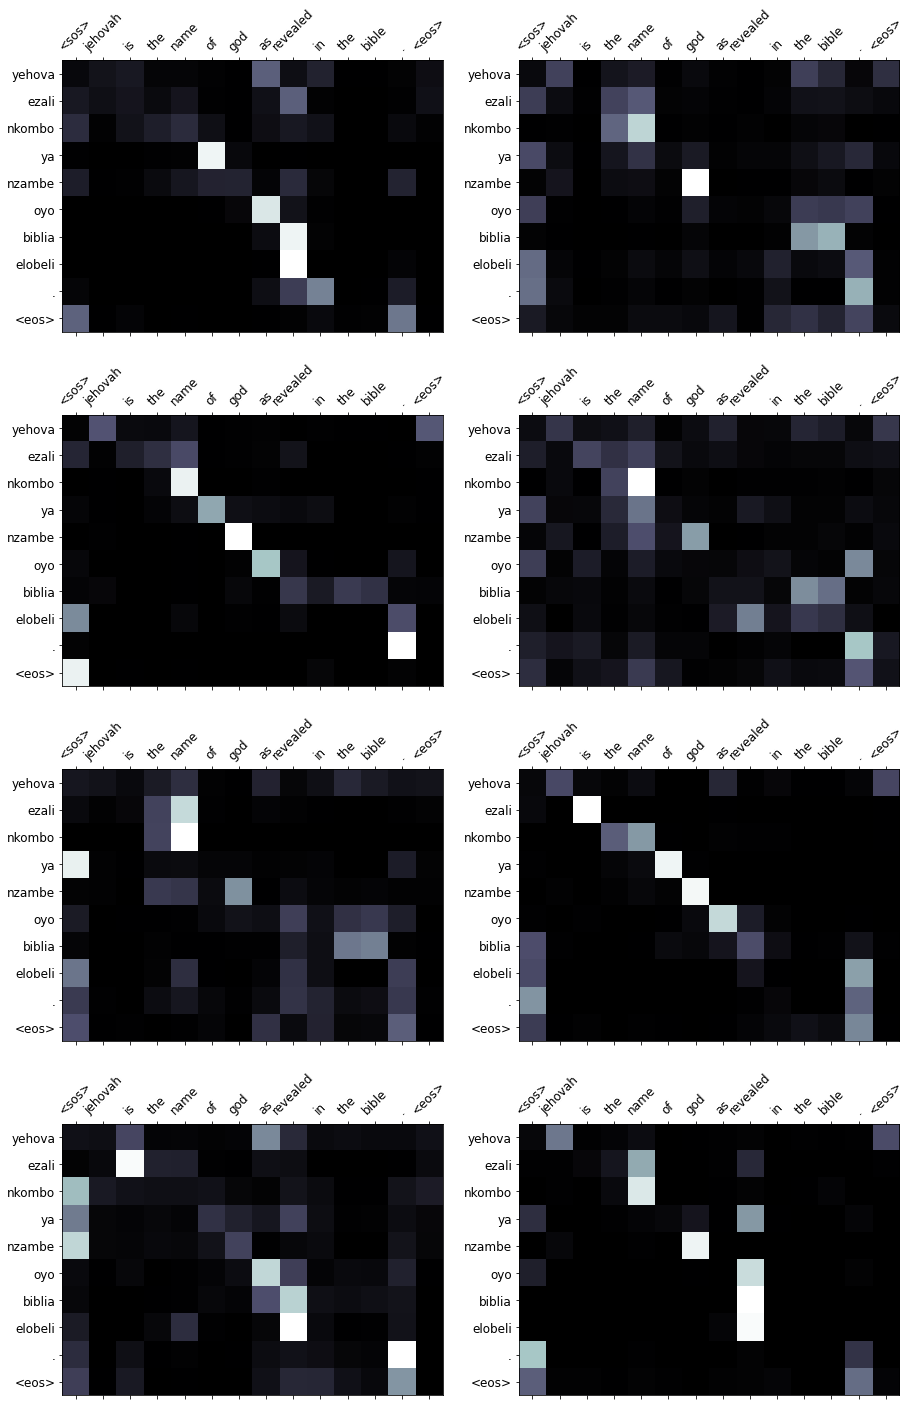

In [39]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [40]:
# example_idx = 10

# src = vars(test_data.examples[example_idx])['src']
# trg = vars(test_data.examples[example_idx])['trg']

# print(f'src = {src}')
# print(f'trg = {trg}')

A decent translation with *young* being omitted.

In [41]:
# translation, attention = translate_sentence(src, SRC, TRG, model, device)

# print(f'predicted trg = {translation}')

In [42]:
# display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [43]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 35.08, which beats the 33.3 of the convolutional sequence-to-sequence model and 28.2 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [44]:
bleu_score = calculate_bleu(valid_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 54.74


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP. 